In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# A quick intro to PyMC3 for exoplaneteers

[Hamiltonian Monte Carlo (HMC)](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo) methods haven't been widely used in astrophysics, but they are the standard methods for probabilistic inference using Markov chain Monte Carlo (MCMC) in many other fields.
*exoplanet* is designed to provide the building blocks for fitting many exoplanet datasets using this technology, and this tutorial presents some of the basic features of the [PyMC3](https://docs.pymc.io/) modeling language and inference engine.
The [documentation for PyMC3](https://docs.pymc.io/) includes many other tutorials that you should check out to get more familiar with the features that are available.

In this tutorial, we will go through two simple examples of fitting some data using PyMC3.
The first is the classic fitting a line to data with unknown error bars, and the second is a more relevant example where we fit a radial velocity model to the public radial velocity observations of [51 Peg](https://en.wikipedia.org/wiki/51_Pegasi).
You can read more about fitting lines to data [in the bible of line fitting](https://arxiv.org/abs/1008.4686) and you can see another example of fitting the 51 Peg data using HMC (this time using [Stan](http://mc-stan.org)) [here](https://dfm.io/posts/stan-c++/).

## Hello world (AKA fitting a line to data)

My standard intro to a new modeling language or inference framework is to fit a line to data.
So. Let's do that with PyMC3.

To start, we'll generate some fake data using a linear model.
Feel free to change the random number seed to try out a different dataset.

Text(0, 0.5, 'y')

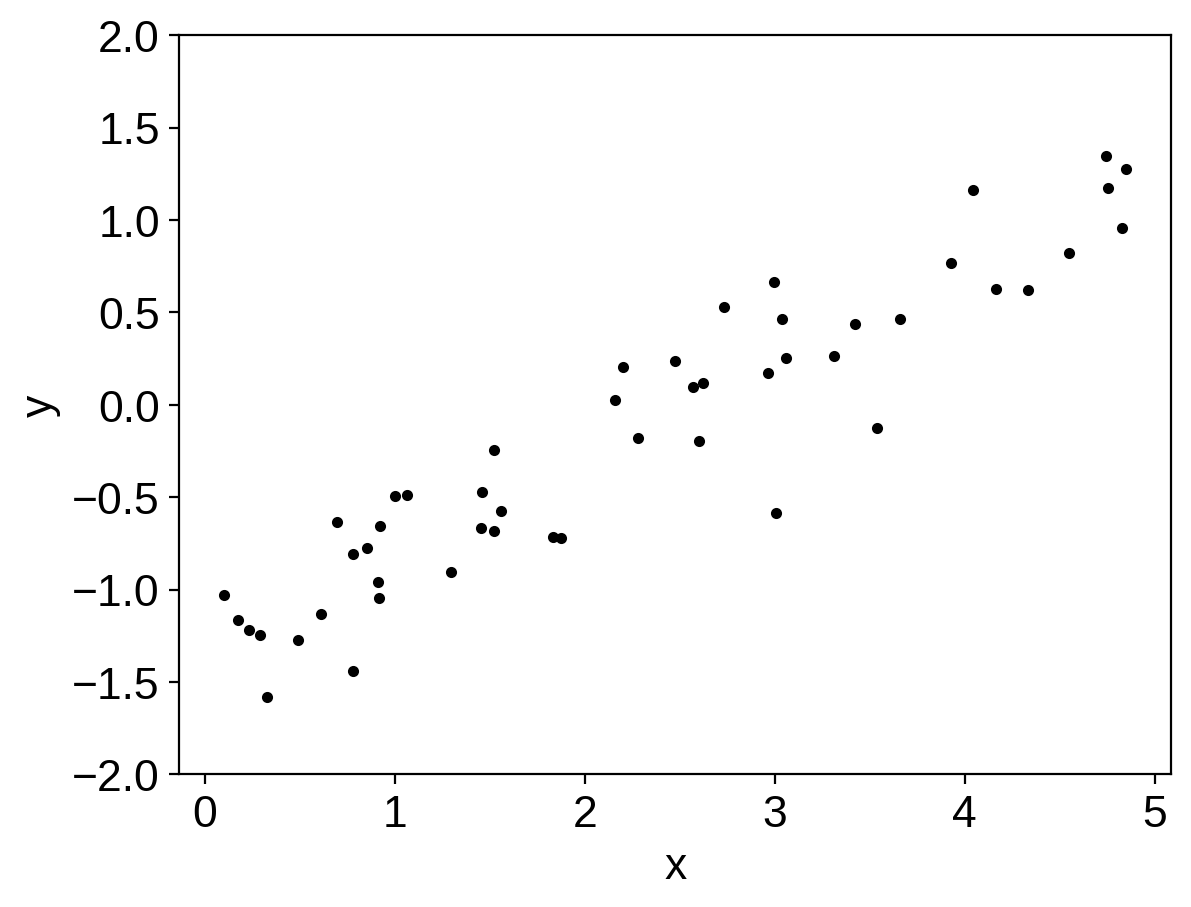

In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

true_m = 0.5
true_b = -1.3
true_logs = np.log(0.3)

x = np.sort(np.random.uniform(0, 5, 50))
y = true_b + true_m * x + np.exp(true_logs) * np.random.randn(len(x))

plt.plot(x, y, ".k")
plt.ylim(-2, 2)
plt.xlabel("x")
plt.ylabel("y")

To fit a model to these data, our model will have 3 parameters: the slope $m$, the intercept $b$, and the log of the uncertainty $\log(\sigma)$.
To start, let's choose broad uniform priors on these parameters:

$$
\begin{eqnarray}
p(m) &=& \left\{\begin{array}{ll}
1/10 & \mathrm{if}\,-5 < m < 5 \\
0 & \mathrm{otherwise} \\
\end{array}\right. \\
p(b) &=& \left\{\begin{array}{ll}
1/10 & \mathrm{if}\,-5 < b < 5 \\
0 & \mathrm{otherwise} \\
\end{array}\right. \\
p(\log(\sigma)) &=& \left\{\begin{array}{ll}
1/10 & \mathrm{if}\,-5 < b < 5 \\
0 & \mathrm{otherwise} \\
\end{array}\right.
\end{eqnarray}
$$

Then, the log-likelihood function will be

$$
\log p(\{y_n\}\,|\,m,\,b,\,\log(\sigma)) = -\frac{1}{2}\sum_{n=1}^N \left[\frac{(y_n - m\,x_n - b)^2}{\sigma^2} + \log(2\,\pi\,\sigma^2)\right]
$$

[**Note:** the second normalization term is needed in this model because we are fitting for $\sigma$ and the second term is *not* a constant.]

Another way of writing this model that might not be familiar is the following:

$$
\begin{eqnarray}
m &\sim& \mathrm{Uniform}(-5,\,5) \\
b &\sim& \mathrm{Uniform}(-5,\,5) \\
\log(\sigma) &\sim& \mathrm{Uniform}(-5,\,5) \\
y_n &\sim& \mathrm{Normal}(m\,x_n+b,\,\sigma)
\end{eqnarray}
$$

This is the way that a model like this is often defined in statistics and it will be useful when we implement out model in PyMC3 so take a moment to make sure that you understand the notation.

Now, let's implement this model in PyMC3.
The documentation for the distributions available in PyMC3's modeling language can be [found here](https://docs.pymc.io/api/distributions/continuous.html) and these will come in handy as you go on to write your own models.

In [4]:
import pymc3 as pm

with pm.Model() as model:

    # Define the priors on each parameter:
    m = pm.Uniform("m", lower=-5, upper=5)
    b = pm.Uniform("b", lower=-5, upper=5)
    logs = pm.Uniform("logs", lower=-5, upper=5)

    # Define the likelihood. A few comments:
    #  1. For mathematical operations like "exp", you can't use
    #     numpy. Instead, use the mathematical operations defined
    #     in "pm.math".
    #  2. To condition on data, you use the "observed" keyword
    #     argument to any distribution. In this case, we want to
    #     use the "Normal" distribution (look up the docs for
    #     this).
    pm.Normal("obs", mu=m * x + b, sd=pm.math.exp(logs), observed=y)

    # This is how you will sample the model. Take a look at the
    # docs to see that other parameters that are available.
    trace = pm.sample(draws=1000, tune=1000, chains=2, cores=2)

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs, b, m]


Sampling 2 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 81/4000 [00:00<00:04, 794.16draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 153/4000 [00:00<00:05, 768.57draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 224/4000 [00:00<00:05, 746.54draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 290/4000 [00:00<00:05, 717.21draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 360/4000 [00:00<00:05, 710.90draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 461/4000 [00:00<00:04, 776.02draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 577/4000 [00:00<00:03, 859.88draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 689/4000 [00:00<00:03, 921.75draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 808/4000 [00:00<00:03, 988.33draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 921/4000 [00:01<00:03, 1025.54draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 1042/4000 [00:01<00:02, 1073.28draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 1158/4000 [00:01<00:02, 1094.35draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 1269/4000 [00:01<00:02, 1049.10draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 1381/4000 [00:01<00:02, 1068.28draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 1497/4000 [00:01<00:02, 1091.63draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 1617/4000 [00:01<00:02, 1121.90draws/s]

Sampling 2 chains, 0 divergences:  44%|████▎     | 1741/4000 [00:01<00:01, 1152.81draws/s]

Sampling 2 chains, 0 divergences:  46%|████▋     | 1858/4000 [00:01<00:01, 1136.42draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 1974/4000 [00:01<00:01, 1142.57draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 2092/4000 [00:02<00:01, 1150.56draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 2219/4000 [00:02<00:01, 1179.18draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 2339/4000 [00:02<00:01, 1184.34draws/s]

Sampling 2 chains, 0 divergences:  61%|██████▏   | 2458/4000 [00:02<00:01, 1180.00draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 2589/4000 [00:02<00:01, 1214.64draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 2719/4000 [00:02<00:01, 1236.76draws/s]

Sampling 2 chains, 0 divergences:  71%|███████▏  | 2850/4000 [00:02<00:00, 1253.89draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 2976/4000 [00:02<00:00, 1252.14draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 3102/4000 [00:02<00:00, 1245.11draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 3227/4000 [00:02<00:00, 1231.45draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 3351/4000 [00:03<00:00, 1207.16draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 3474/4000 [00:03<00:00, 1210.72draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 3596/4000 [00:03<00:00, 1212.19draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 3718/4000 [00:03<00:00, 1194.65draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 3838/4000 [00:03<00:00, 1187.56draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 3957/4000 [00:03<00:00, 1062.37draws/s]

Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1088.30draws/s]

Now since we now have samples, let's make some diagnostic plots.
The first plot to look at is the "traceplot" implemented in PyMC3.
In this plot, you'll see the marginalized distribution for each parameter on the left and the trace plot (parameter value as a function of step number) on the right.
In each panel, you should see two lines with different colors.
These are the results of different independent chains and if the results are substantially different in the different chains then there is probably something going wrong.

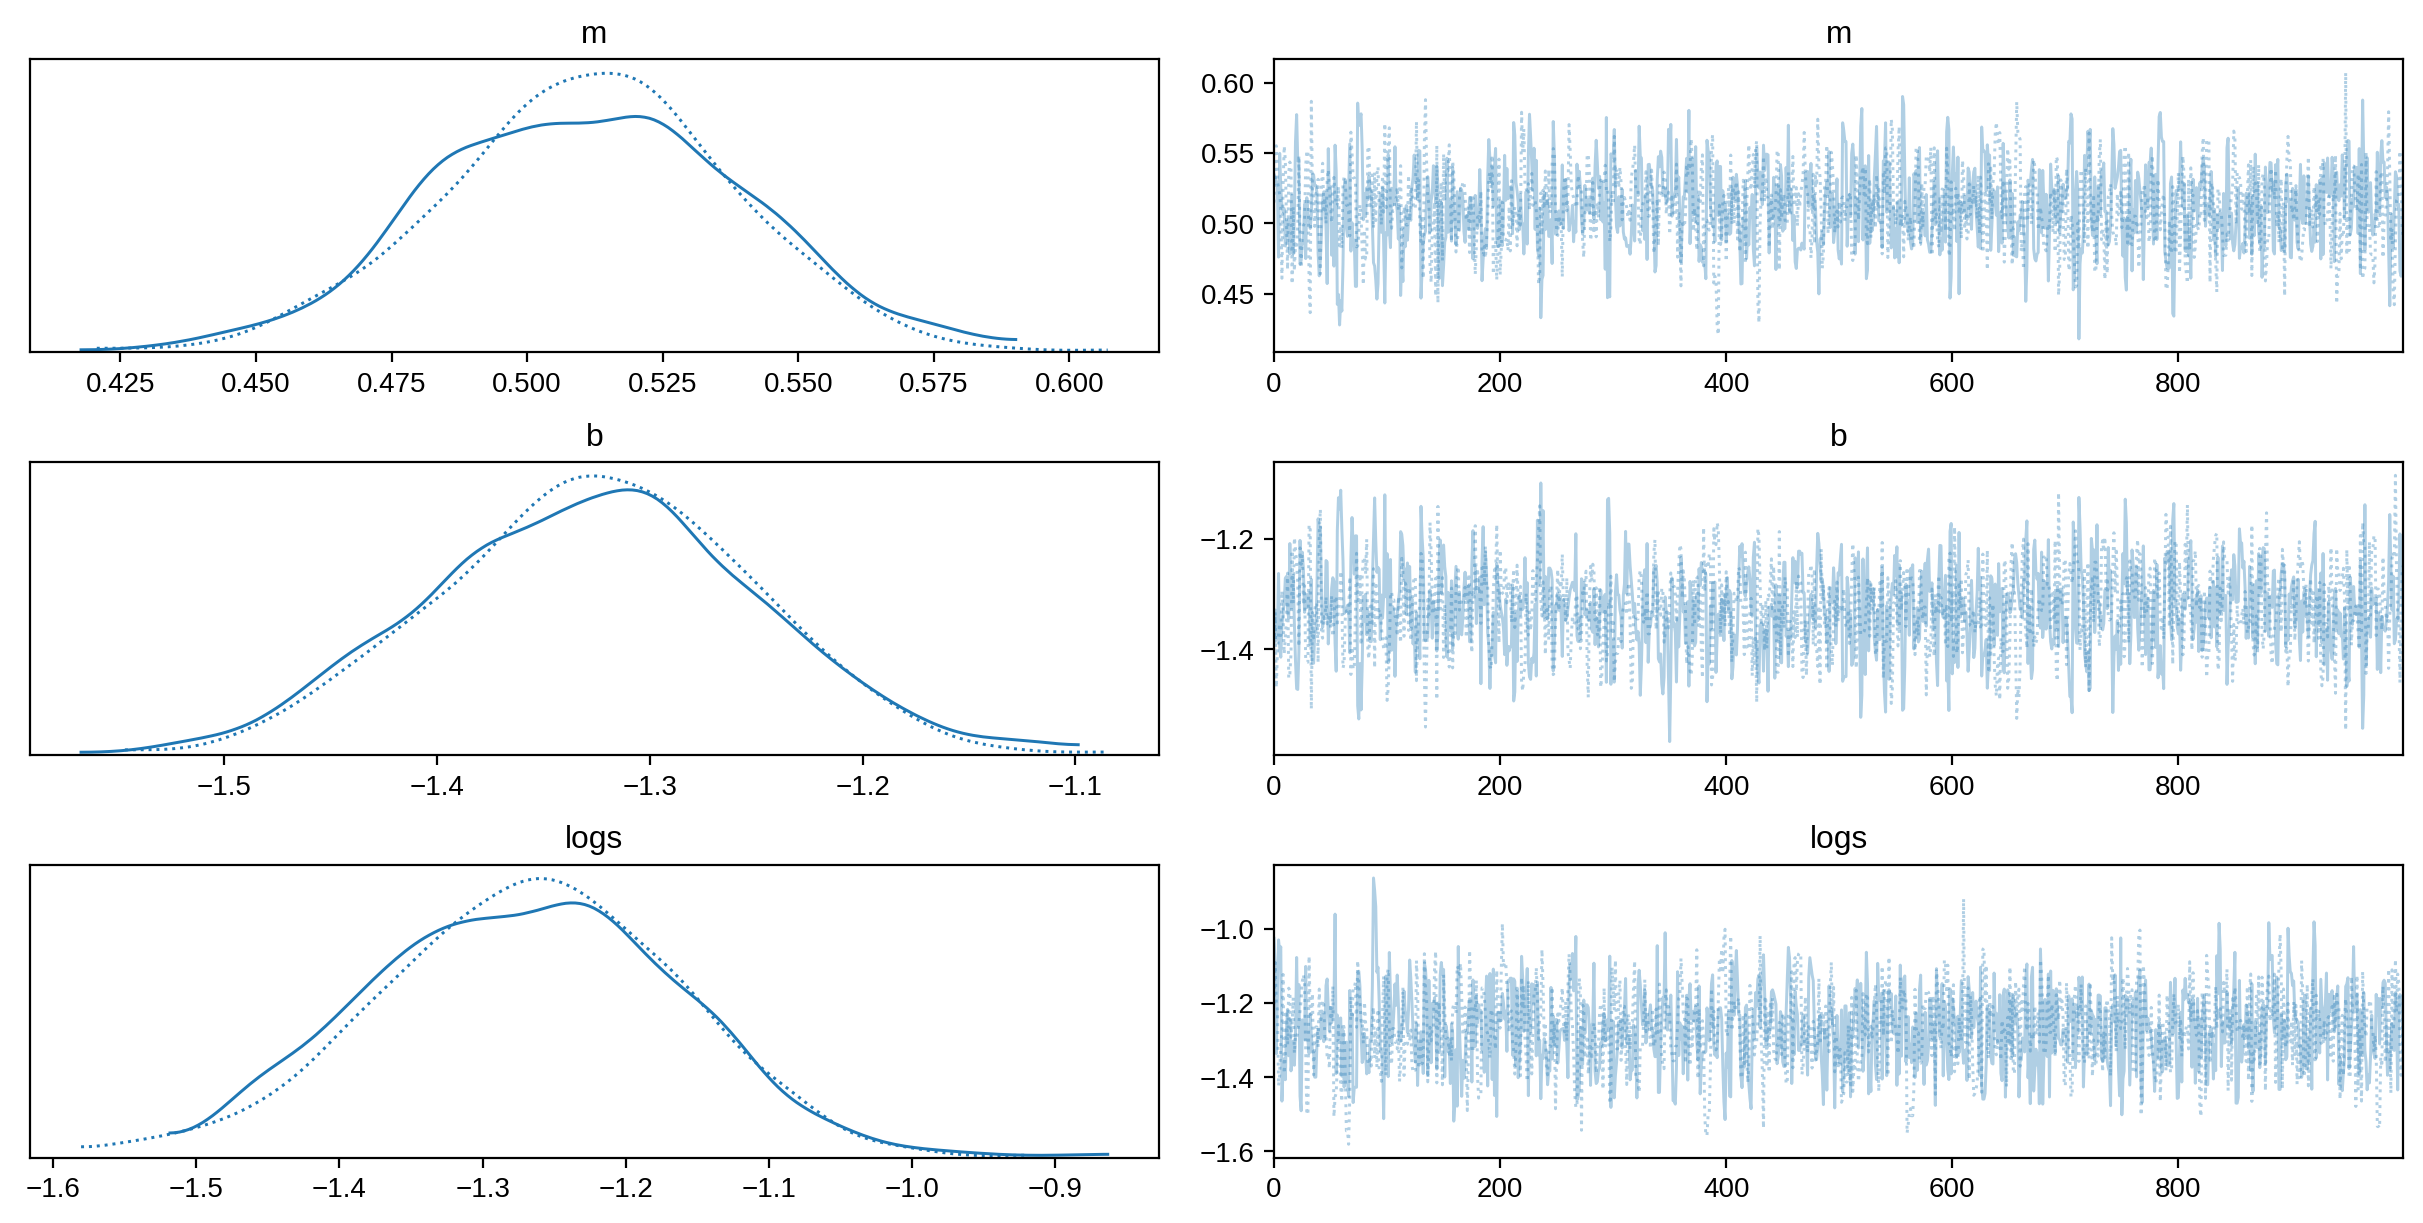

In [5]:
_ = pm.traceplot(trace, var_names=["m", "b", "logs"])

It's also good to quantify that "looking substantially different" argument.
This is implemented in PyMC3 as the "summary" function.
In this table, some of the key columns to look at are `n_eff` and `Rhat`.
* `n_eff` shows an estimate of the number of effective (or independent) samples for that parameter. In this case, `n_eff` should probably be around 500 per chain (there should have been 2 chains run).
* `Rhat` shows the [Gelman–Rubin statistic](https://docs.pymc.io/api/diagnostics.html#pymc3.diagnostics.gelman_rubin) and it should be close to 1.

In [6]:
pm.summary(trace, var_names=["m", "b", "logs"])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
m,0.511,0.028,0.457,0.560,0.001,0.001,1010.0,1010.0,1010.0,1030.0,1.0
b,-1.326,0.074,-1.460,-1.185,0.002,0.002,979.0,979.0,980.0,1202.0,1.0
logs,-1.269,0.105,-1.468,-1.084,0.003,0.002,1080.0,1080.0,1072.0,965.0,1.0


The last diagnostic plot that we'll make here is the [corner plot made using corner.py](https://corner.readthedocs.io).
The easiest way to do this using PyMC3 is to first convert the trace to a [Pandas DataFrame](https://pandas.pydata.org/) and then pass that to `corner.py`.

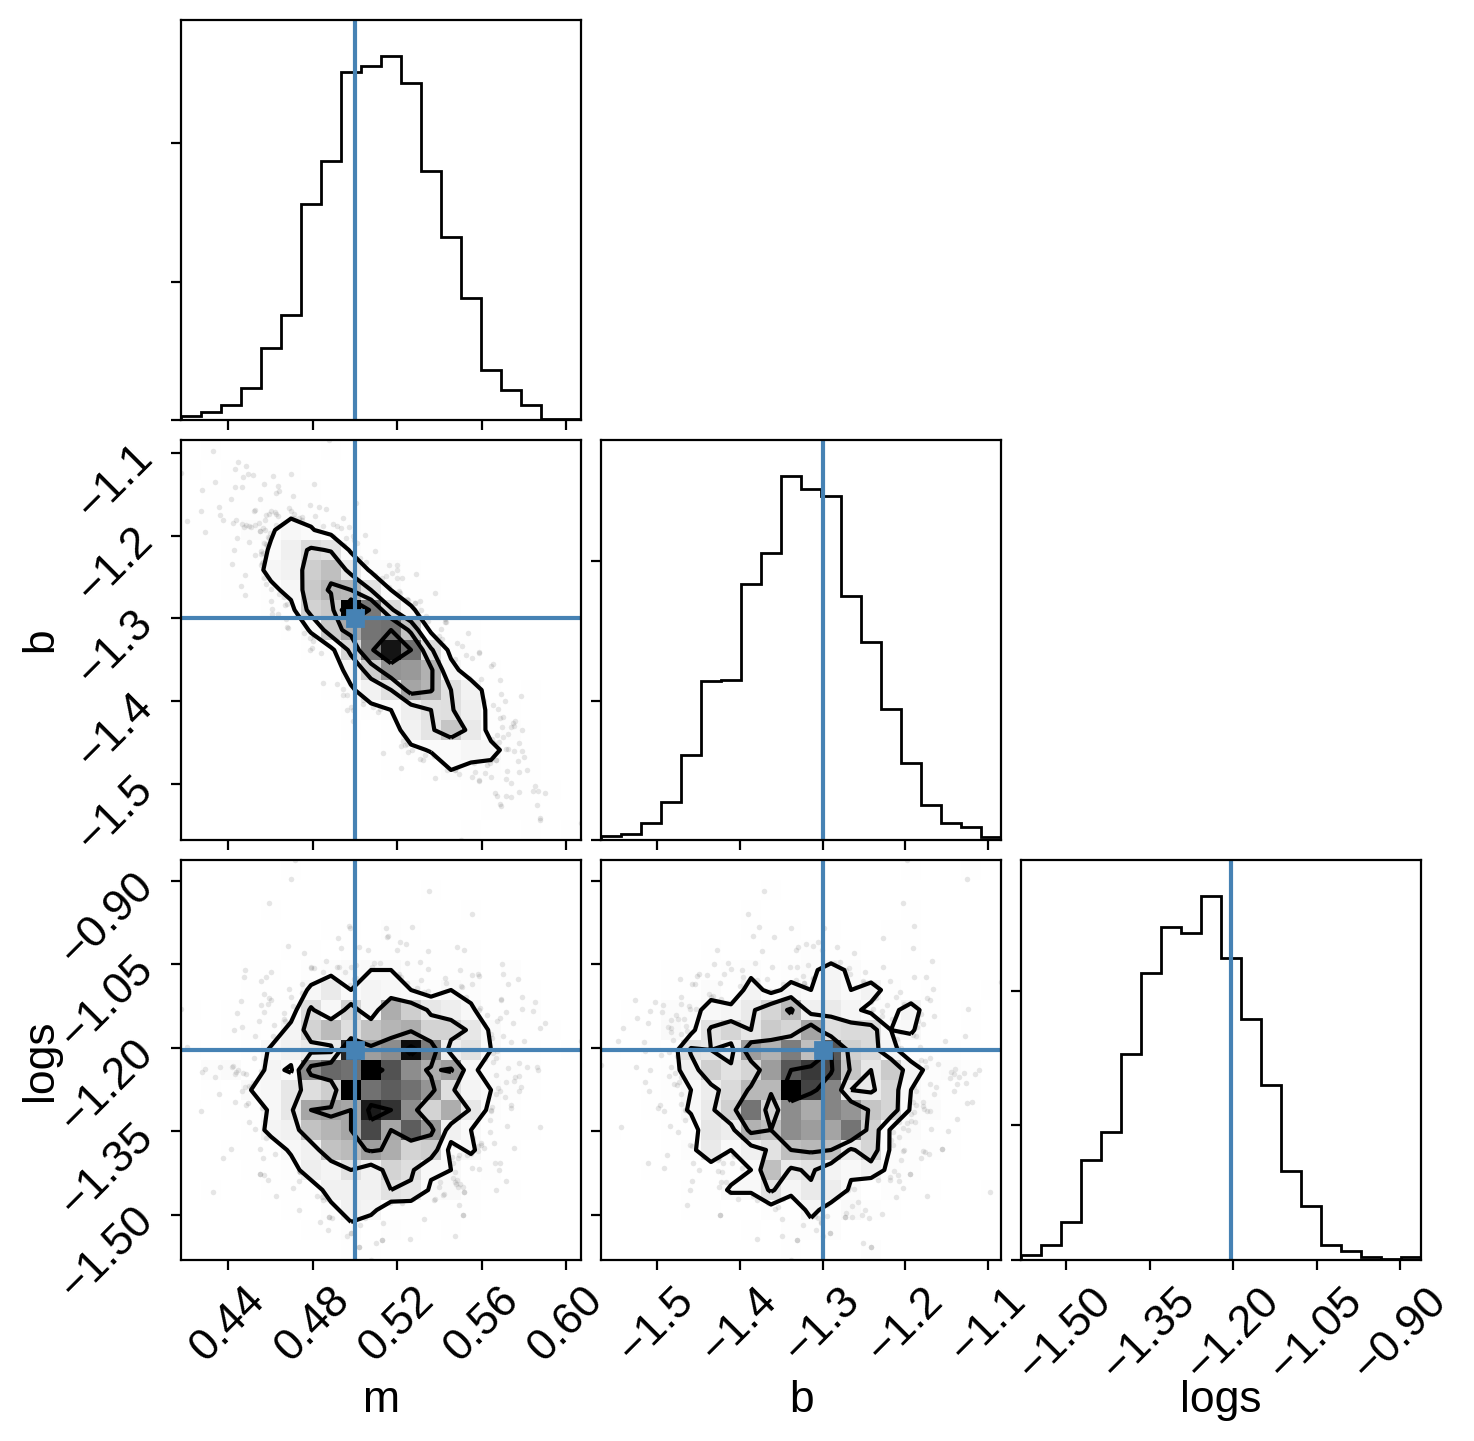

In [7]:
import corner  # https://corner.readthedocs.io

samples = pm.trace_to_dataframe(trace, varnames=["m", "b", "logs"])
_ = corner.corner(samples, truths=[true_m, true_b, true_logs])

**Extra credit:** Here are a few suggestions for things to try out while getting more familiar with PyMC3:

1. Try initializing the parameters using the `testval` argument to the distributions. Does this improve performance in this case? It will substantially improve performance in more complicated examples.
2. Try changing the priors on the parameters. For example, try the "uninformative" prior [recommended by Jake VanderPlas on his blog](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/#Prior-on-Slope-and-Intercept).
3. What happens as you substantially increase or decrease the simulated noise? Does the performance change significantly? Why?

## A more realistic example: radial velocity exoplanets

While the above example was cute, it doesn't really fully exploit the power of PyMC3 and it doesn't really show some of the real issues that you will face when you use PyMC3 as an astronomer.
To get a better sense of how you might use PyMC3 in Real Life™, let's take a look at a more realistic example: fitting a Keplerian orbit to radial velocity observations.

One of the key aspects of this problem that I want to highlight is the fact that PyMC3 (and the underlying model building framework [Theano](http://deeplearning.net/software/theano/)) don't have out-of-the-box support for the root-finding that is required to solve Kepler's equation.
As part of the process of computing a Keplerian RV model, we must solve the equation:

$$
M = E - e\,\sin E
$$

for the eccentric anomaly $E$ given some mean anomaly $M$ and eccentricity $e$.
There are commonly accepted methods of solving this equation using [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method), but if we want to expose that to PyMC3, we have to define a [custom Theano operation](http://deeplearning.net/software/theano/extending/extending_theano.html) with a custom gradient.
I won't go into the details of the math (because [I blogged about it](https://dfm.io/posts/stan-c++/)) and I won't go into the details of the implementation (because [you can take a look at it on GitHub](https://github.com/exoplanet-dev/exoplanet/tree/master/exoplanet/theano_ops/kepler)).
So, for this tutorial, we'll use the custom Kepler solver that is implemented as part of *exoplanet* and fit the publicly available radial velocity observations of the famous exoplanetary system 51 Peg using PyMC3.

First, we need to download the data from the exoplanet archive:

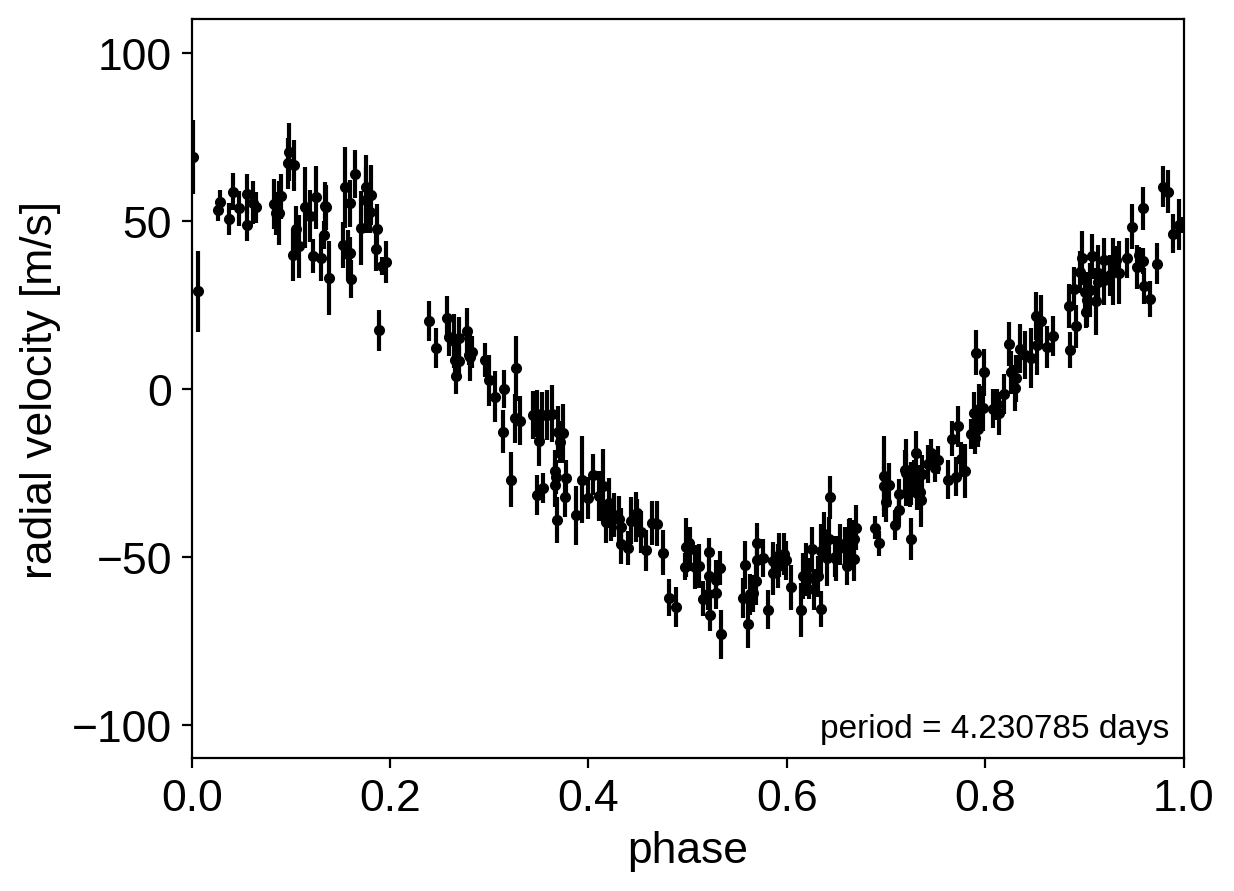

In [8]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

# Download the dataset from the Exoplanet Archive:
url = "https://exoplanetarchive.ipac.caltech.edu/data/ExoData/0113/0113357/data/UID_0113357_RVC_001.tbl"
r = requests.get(url)
if r.status_code != requests.codes.ok:
    r.raise_for_status()
data = np.array(
    [
        l.split()
        for l in r.text.splitlines()
        if not l.startswith("\\") and not l.startswith("|")
    ],
    dtype=float,
)
t, rv, rv_err = data.T
t -= np.mean(t)

# Plot the observations "folded" on the published period:
# Butler et al. (2006) https://arxiv.org/abs/astro-ph/0607493
lit_period = 4.230785
plt.errorbar(
    (t % lit_period) / lit_period, rv, yerr=rv_err, fmt=".k", capsize=0
)
plt.xlim(0, 1)
plt.ylim(-110, 110)
plt.annotate(
    "period = {0:.6f} days".format(lit_period),
    xy=(1, 0),
    xycoords="axes fraction",
    xytext=(-5, 5),
    textcoords="offset points",
    ha="right",
    va="bottom",
    fontsize=12,
)
plt.ylabel("radial velocity [m/s]")
_ = plt.xlabel("phase")

Now, here's the implementation of a radial velocity model in PyMC3.
Some of this will look familiar after the Hello World example, but things are a bit more complicated now.
Take a minute to take a look through this and see if you can follow it.
There's a lot going on, so I want to point out a few things to pay attention to:

1. All of the mathematical operations (for example `exp` and `sqrt`) are being performed using Theano instead of NumPy.
2. All of the parameters have initial guesses provided. This is an example where this makes a big difference because some of the parameters (like period) are very tightly constrained.
3. Some of the lines are wrapped in `Deterministic` distributions. This can be useful because it allows us to track values as the chain progresses even if they're not parameters. For example, after sampling, we will have a sample for `bkg` (the background RV trend) for each step in the chain. This can be especially useful for making plots of the results.
4. Similarly, at the end of the model definition, we compute the RV curve for a single orbit on a fine grid. This can be very useful for diagnosing fits gone wrong.
5. For parameters that specify angles (like $\omega$, called `w` in the model below), it can be inefficient to sample in the angle directly because of the fact that the value wraps around at $2\pi$. Instead, it can be better to sample the unit vector specified by the angle. In practice, this can be achieved by sampling a 2-vector from an isotropic Gaussian and normalizing the components by the norm. This is implemented as part of *exoplanet* in the :class:`exoplanet.distributions.Angle` class.

In [9]:
import theano.tensor as tt

from exoplanet.orbits import get_true_anomaly
from exoplanet.distributions import Angle

with pm.Model() as model:

    # Parameters
    logK = pm.Uniform(
        "logK",
        lower=0,
        upper=np.log(200),
        testval=np.log(0.5 * (np.max(rv) - np.min(rv))),
    )
    logP = pm.Uniform(
        "logP", lower=0, upper=np.log(10), testval=np.log(lit_period)
    )
    phi = pm.Uniform("phi", lower=0, upper=2 * np.pi, testval=0.1)
    e = pm.Uniform("e", lower=0, upper=1, testval=0.1)
    w = Angle("w")
    logjitter = pm.Uniform(
        "logjitter", lower=-10, upper=5, testval=np.log(np.mean(rv_err))
    )
    rv0 = pm.Normal("rv0", mu=0.0, sd=10.0, testval=0.0)
    rvtrend = pm.Normal("rvtrend", mu=0.0, sd=10.0, testval=0.0)

    # Deterministic transformations
    n = 2 * np.pi * tt.exp(-logP)
    P = pm.Deterministic("P", tt.exp(logP))
    K = pm.Deterministic("K", tt.exp(logK))
    cosw = tt.cos(w)
    sinw = tt.sin(w)
    s2 = tt.exp(2 * logjitter)
    t0 = (phi + w) / n

    # The RV model
    bkg = pm.Deterministic("bkg", rv0 + rvtrend * t / 365.25)
    M = n * t - (phi + w)

    # This is the line that uses the custom Kepler solver
    f = get_true_anomaly(M, e + tt.zeros_like(M))
    rvmodel = pm.Deterministic(
        "rvmodel", bkg + K * (cosw * (tt.cos(f) + e) - sinw * tt.sin(f))
    )

    # Condition on the observations
    err = tt.sqrt(rv_err ** 2 + tt.exp(2 * logjitter))
    pm.Normal("obs", mu=rvmodel, sd=err, observed=rv)

    # Compute the phased RV signal
    phase = np.linspace(0, 1, 500)
    M_pred = 2 * np.pi * phase - (phi + w)
    f_pred = get_true_anomaly(M_pred, e + tt.zeros_like(M_pred))
    rvphase = pm.Deterministic(
        "rvphase", K * (cosw * (tt.cos(f_pred) + e) - sinw * tt.sin(f_pred))
    )

In this case, I've found that it is useful to first optimize the parameters to find the "maximum a posteriori" (MAP) parameters and then start the sampler from there.
This is useful here because MCMC is not designed to *find* the maximum of the posterior; it's just meant to sample the shape of the posterior.
The performance of all MCMC methods can be really bad when the initialization isn't good (especially when some parameters are very well constrained).
To find the maximum a posteriori parameters using PyMC3, you can use the :func:`exoplanet.optimize` function:

In [10]:
from exoplanet import optimize

with model:
    map_params = optimize()

optimizing logp for variables: [rvtrend, rv0, logjitter, w, e, phi, logP, logK]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.325843e+03]

1it [00:00, 430.27it/s, logp=-1.325843e+03]

2it [00:00, 491.02it/s, logp=-2.286484e+03]

3it [00:00, 589.25it/s, logp=-4.210674e+03]

4it [00:00, 631.10it/s, logp=-6.113268e+03]

5it [00:00, 663.99it/s, logp=-1.325839e+03]

6it [00:00, 647.79it/s, logp=-1.325831e+03]

7it [00:00, 677.78it/s, logp=-1.325800e+03]

8it [00:00, 636.55it/s, logp=-1.325672e+03]

9it [00:00, 653.70it/s, logp=-1.325163e+03]

10it [00:00, 671.20it/s, logp=-1.323131e+03]

11it [00:00, 671.39it/s, logp=-1.315110e+03]

12it [00:00, 686.47it/s, logp=-1.284659e+03]

13it [00:00, 687.23it/s, logp=-1.163262e+03]

14it [00:00, 688.43it/s, logp=-1.893373e+04]

15it [00:00, 690.79it/s, logp=-1.156573e+03]

16it [00:00, 693.99it/s, logp=-1.107289e+03]

17it [00:00, 692.53it/s, logp=-1.105619e+03]

18it [00:00, 694.11it/s, logp=-2.292822e+04]

19it [00:00, 696.93it/s, logp=-1.104877e+03]

20it [00:00, 697.24it/s, logp=-1.096983e+03]

21it [00:00, 686.36it/s, logp=-1.081008e+03]

22it [00:00, 686.16it/s, logp=-1.048977e+03]

23it [00:00, 690.60it/s, logp=-9.520559e+02]

24it [00:00, 686.24it/s, logp=-1.302657e+03]

25it [00:00, 684.53it/s, logp=-9.204437e+02]

26it [00:00, 658.53it/s, logp=-8.748183e+02]

27it [00:00, 654.33it/s, logp=-8.692717e+02]

28it [00:00, 654.30it/s, logp=-8.604222e+02]

29it [00:00, 657.49it/s, logp=-8.532805e+02]

30it [00:00, 659.09it/s, logp=-8.560545e+02]

31it [00:00, 663.13it/s, logp=-8.518300e+02]

32it [00:00, 665.59it/s, logp=-8.504929e+02]

33it [00:00, 666.02it/s, logp=-8.483210e+02]

34it [00:00, 666.05it/s, logp=-8.450935e+02]

35it [00:00, 669.17it/s, logp=-8.416384e+02]

36it [00:00, 670.65it/s, logp=-8.384048e+02]

37it [00:00, 672.09it/s, logp=-8.376934e+02]

38it [00:00, 673.37it/s, logp=-8.373709e+02]

39it [00:00, 673.26it/s, logp=-8.368934e+02]

40it [00:00, 669.00it/s, logp=-8.363872e+02]

41it [00:00, 670.99it/s, logp=-8.360345e+02]

42it [00:00, 672.70it/s, logp=-8.355539e+02]

43it [00:00, 674.54it/s, logp=-8.353694e+02]

44it [00:00, 676.15it/s, logp=-8.353021e+02]

45it [00:00, 677.84it/s, logp=-8.352493e+02]

46it [00:00, 678.77it/s, logp=-8.352413e+02]

47it [00:00, 680.85it/s, logp=-8.352367e+02]

48it [00:00, 681.99it/s, logp=-8.352346e+02]

49it [00:00, 682.93it/s, logp=-8.352344e+02]

50it [00:00, 683.67it/s, logp=-8.352343e+02]

51it [00:00, 682.68it/s, logp=-8.352341e+02]

52it [00:00, 684.83it/s, logp=-8.352339e+02]

53it [00:00, 685.04it/s, logp=-8.352334e+02]

54it [00:00, 686.18it/s, logp=-8.352324e+02]

55it [00:00, 676.40it/s, logp=-8.352307e+02]

56it [00:00, 677.01it/s, logp=-8.352276e+02]

57it [00:00, 675.92it/s, logp=-8.352224e+02]

58it [00:00, 677.44it/s, logp=-8.352143e+02]

59it [00:00, 678.78it/s, logp=-8.352049e+02]

60it [00:00, 679.57it/s, logp=-8.351969e+02]

61it [00:00, 663.83it/s, logp=-8.351925e+02]

62it [00:00, 665.41it/s, logp=-8.351914e+02]

63it [00:00, 666.16it/s, logp=-8.351913e+02]

64it [00:00, 667.48it/s, logp=-8.351913e+02]

65it [00:00, 668.33it/s, logp=-8.351913e+02]

66it [00:00, 669.40it/s, logp=-8.351913e+02]

67it [00:00, 670.95it/s, logp=-8.351913e+02]

68it [00:00, 676.52it/s, logp=-8.351913e+02]

68it [00:00, 676.52it/s, logp=-8.351913e+02]

69it [00:00, 676.52it/s, logp=-8.351913e+02]

70it [00:00, 676.52it/s, logp=-8.351913e+02]

71it [00:00, 676.52it/s, logp=-8.351913e+02]

72it [00:00, 676.52it/s, logp=-8.351913e+02]

73it [00:00, 676.52it/s, logp=-8.351913e+02]

74it [00:00, 676.52it/s, logp=-8.351913e+02]

75it [00:00, 676.52it/s, logp=-8.351913e+02]

76it [00:00, 676.52it/s, logp=-8.351913e+02]

77it [00:00, 676.52it/s, logp=-8.351913e+02]

78it [00:00, 676.52it/s, logp=-8.351913e+02]

79it [00:00, 676.52it/s, logp=-8.351913e+02]

80it [00:00, 676.52it/s, logp=-8.351913e+02]

81it [00:00, 676.52it/s, logp=-8.351913e+02]

82it [00:00, 676.52it/s, logp=-8.351913e+02]

83it [00:00, 676.52it/s, logp=-8.351913e+02]

84it [00:00, 676.52it/s, logp=-8.351913e+02]

85it [00:00, 676.52it/s, logp=-8.351913e+02]

86it [00:00, 676.52it/s, logp=-8.351913e+02]

87it [00:00, 676.52it/s, logp=-8.351913e+02]

88it [00:00, 676.52it/s, logp=-8.351913e+02]

89it [00:00, 676.52it/s, logp=-8.351913e+02]

90it [00:00, 676.52it/s, logp=-8.351913e+02]

91it [00:00, 676.52it/s, logp=-8.351913e+02]

92it [00:00, 676.52it/s, logp=-8.351913e+02]

93it [00:00, 676.52it/s, logp=-8.351913e+02]

94it [00:00, 676.52it/s, logp=-8.351913e+02]

95it [00:00, 676.52it/s, logp=-8.351913e+02]

96it [00:00, 676.52it/s, logp=-8.351913e+02]

97it [00:00, 676.52it/s, logp=-8.351913e+02]

98it [00:00, 676.52it/s, logp=-8.351913e+02]

99it [00:00, 676.52it/s, logp=-8.351913e+02]

100it [00:00, 676.52it/s, logp=-8.351913e+02]

101it [00:00, 676.52it/s, logp=-8.351913e+02]

102it [00:00, 676.52it/s, logp=-8.351913e+02]

103it [00:00, 676.52it/s, logp=-8.351913e+02]

104it [00:00, 676.52it/s, logp=-8.351913e+02]

105it [00:00, 676.52it/s, logp=-8.351913e+02]

106it [00:00, 676.52it/s, logp=-8.351913e+02]

107it [00:00, 676.52it/s, logp=-8.351913e+02]

108it [00:00, 676.52it/s, logp=-8.351913e+02]

109it [00:00, 676.52it/s, logp=-8.351913e+02]

110it [00:00, 676.52it/s, logp=-8.351913e+02]

111it [00:00, 676.52it/s, logp=-8.351913e+02]

112it [00:00, 676.52it/s, logp=-8.351913e+02]

113it [00:00, 676.52it/s, logp=-8.351913e+02]

114it [00:00, 676.52it/s, logp=-8.351913e+02]

115it [00:00, 676.52it/s, logp=-8.351913e+02]

116it [00:00, 676.52it/s, logp=-8.351913e+02]

117it [00:00, 676.52it/s, logp=-8.351913e+02]

118it [00:00, 676.52it/s, logp=-8.351913e+02]

119it [00:00, 676.52it/s, logp=-8.351913e+02]

120it [00:00, 676.52it/s, logp=-8.351913e+02]

121it [00:00, 676.52it/s, logp=-8.351913e+02]

122it [00:00, 676.52it/s, logp=-8.351913e+02]

123it [00:00, 676.52it/s, logp=-8.351913e+02]

124it [00:00, 676.52it/s, logp=-8.351913e+02]

125it [00:00, 676.52it/s, logp=-8.351913e+02]

126it [00:00, 676.52it/s, logp=-8.351913e+02]

127it [00:00, 676.52it/s, logp=-8.351913e+02]

128it [00:00, 676.52it/s, logp=-8.351913e+02]

129it [00:00, 676.52it/s, logp=-8.351913e+02]

130it [00:00, 676.52it/s, logp=-8.351913e+02]

131it [00:00, 676.52it/s, logp=-8.351913e+02]

132it [00:00, 676.52it/s, logp=-8.351913e+02]

133it [00:00, 676.52it/s, logp=-8.351913e+02]

134it [00:00, 676.52it/s, logp=-8.351913e+02]

135it [00:00, 676.52it/s, logp=-8.351913e+02]

136it [00:00, 676.52it/s, logp=-8.351913e+02]

137it [00:00, 676.52it/s, logp=-8.351913e+02]

138it [00:00, 676.52it/s, logp=-8.351913e+02]

139it [00:00, 676.52it/s, logp=-8.351913e+02]

140it [00:00, 676.52it/s, logp=-8.351913e+02]

141it [00:00, 676.52it/s, logp=-8.351913e+02]

142it [00:00, 693.40it/s, logp=-8.351913e+02]

142it [00:00, 693.40it/s, logp=-8.351913e+02]

143it [00:00, 693.40it/s, logp=-8.351913e+02]

144it [00:00, 693.40it/s, logp=-8.351913e+02]

145it [00:00, 693.40it/s, logp=-8.351913e+02]

146it [00:00, 693.40it/s, logp=-8.351913e+02]

147it [00:00, 693.40it/s, logp=-8.351913e+02]

148it [00:00, 693.40it/s, logp=-8.351913e+02]

149it [00:00, 693.40it/s, logp=-8.351913e+02]

150it [00:00, 693.40it/s, logp=-8.351913e+02]

151it [00:00, 693.40it/s, logp=-8.351913e+02]

152it [00:04, 34.02it/s, logp=-8.351913e+02] 


message: Desired error not necessarily achieved due to precision loss.
logp: -1325.8433398976674 -> -835.1912653583939


Let's make a plot to check that this initialization looks reasonable.
In the top plot, we're looking at the RV observations as a function of time with the initial guess for the long-term trend overplotted in blue.
In the lower panel, we plot the "folded" curve where we have wrapped the observations onto the best-fit period and the prediction for a single overplotted in orange.
If this doesn't look good, try adjusting the initial guesses for the parameters and see if you can get a better fit.

**Exercise:** Try changing the initial guesses for the parameters (as specified by the `testval` argument) and see how sensitive the results are to these values. Are there some parameters that are less important? Why is this?

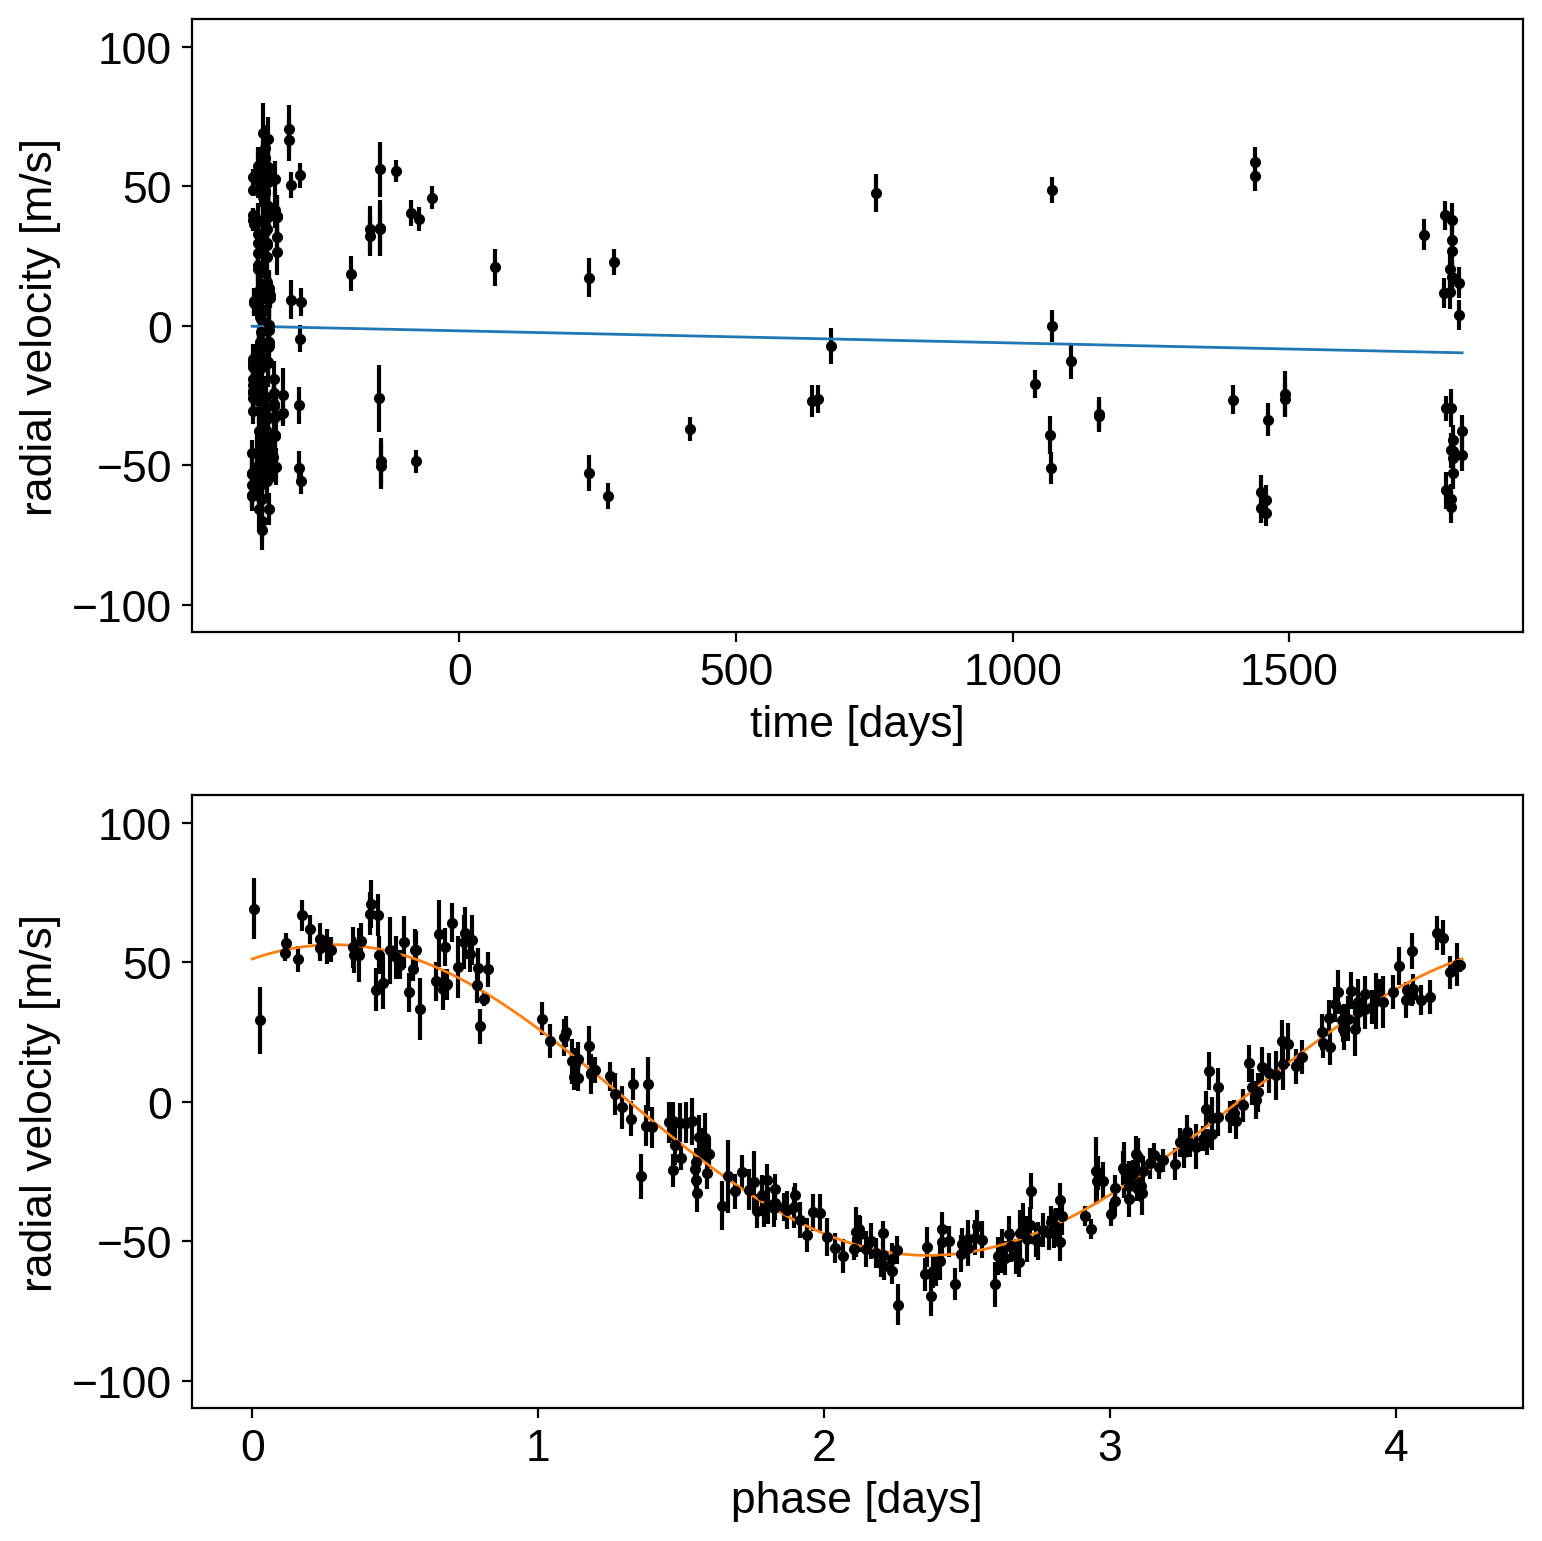

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8))

period = map_params["P"]

ax = axes[0]
ax.errorbar(t, rv, yerr=rv_err, fmt=".k")
ax.plot(t, map_params["bkg"], color="C0", lw=1)
ax.set_ylim(-110, 110)
ax.set_ylabel("radial velocity [m/s]")
ax.set_xlabel("time [days]")

ax = axes[1]
ax.errorbar(t % period, rv - map_params["bkg"], yerr=rv_err, fmt=".k")
ax.plot(phase * period, map_params["rvphase"], color="C1", lw=1)
ax.set_ylim(-110, 110)
ax.set_ylabel("radial velocity [m/s]")
ax.set_xlabel("phase [days]")

plt.tight_layout()

Now let's sample the posterior starting from our MAP estimate.

In [12]:
with model:
    trace = pm.sample(
        draws=2000, tune=1000, start=map_params, chains=2, cores=2
    )

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (2 chains in 2 jobs)


NUTS: [rvtrend, rv0, logjitter, w, e, phi, logP, logK]


Sampling 2 chains, 0 divergences:   0%|          | 0/6000 [00:00<?, ?draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 11/6000 [00:00<01:12, 82.50draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 14/6000 [00:00<02:12, 45.21draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 17/6000 [00:00<04:01, 24.81draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 20/6000 [00:00<04:06, 24.21draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 23/6000 [00:00<04:26, 22.46draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 26/6000 [00:01<05:18, 18.77draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 28/6000 [00:01<05:33, 17.93draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 30/6000 [00:01<06:09, 16.15draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 32/6000 [00:01<06:11, 16.07draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 34/6000 [00:01<06:16, 15.86draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 38/6000 [00:01<05:24, 18.36draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 40/6000 [00:01<05:46, 17.21draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 42/6000 [00:01<05:54, 16.82draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 44/6000 [00:02<06:00, 16.54draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 47/6000 [00:02<05:32, 17.89draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 49/6000 [00:02<05:42, 17.37draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 51/6000 [00:02<05:46, 17.15draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 54/6000 [00:02<05:17, 18.74draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 56/6000 [00:02<05:32, 17.89draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 58/6000 [00:02<05:40, 17.45draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 60/6000 [00:02<05:45, 17.22draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 63/6000 [00:03<05:16, 18.76draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 66/6000 [00:03<04:54, 20.12draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 69/6000 [00:03<04:42, 21.00draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 72/6000 [00:03<04:51, 20.31draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 75/6000 [00:03<04:40, 21.13draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 78/6000 [00:03<04:32, 21.72draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 81/6000 [00:03<05:17, 18.62draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 83/6000 [00:04<05:34, 17.71draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 86/6000 [00:04<05:07, 19.25draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 89/6000 [00:04<05:18, 18.57draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 91/6000 [00:04<05:28, 17.97draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 94/6000 [00:04<04:59, 19.69draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 97/6000 [00:04<04:43, 20.84draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 100/6000 [00:04<05:22, 18.30draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 103/6000 [00:05<05:00, 19.60draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 106/6000 [00:05<05:01, 19.53draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 109/6000 [00:05<04:42, 20.86draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 112/6000 [00:05<05:29, 17.86draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 114/6000 [00:05<05:40, 17.29draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 117/6000 [00:05<05:12, 18.80draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 120/6000 [00:05<04:54, 19.99draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 123/6000 [00:06<05:07, 19.14draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 126/6000 [00:06<04:48, 20.38draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 129/6000 [00:06<04:38, 21.09draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 132/6000 [00:06<05:18, 18.43draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 135/6000 [00:06<04:59, 19.61draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 138/6000 [00:06<05:11, 18.80draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 141/6000 [00:07<04:48, 20.31draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 144/6000 [00:07<05:18, 18.41draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 146/6000 [00:07<05:36, 17.42draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 148/6000 [00:07<05:48, 16.78draws/s]

Sampling 2 chains, 0 divergences:   2%|▎         | 150/6000 [00:07<05:51, 16.62draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 152/6000 [00:07<05:53, 16.56draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 154/6000 [00:07<05:57, 16.34draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 156/6000 [00:07<05:39, 17.23draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 158/6000 [00:08<05:43, 17.02draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 161/6000 [00:08<05:13, 18.61draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 163/6000 [00:08<05:29, 17.73draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 165/6000 [00:08<05:40, 17.15draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 168/6000 [00:08<05:12, 18.63draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 170/6000 [00:08<05:30, 17.64draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 172/6000 [00:08<05:42, 17.02draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 175/6000 [00:08<05:11, 18.68draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 177/6000 [00:09<05:24, 17.95draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 180/6000 [00:09<05:03, 19.21draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 182/6000 [00:09<05:21, 18.12draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 184/6000 [00:09<05:37, 17.23draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 186/6000 [00:09<05:47, 16.72draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 189/6000 [00:09<05:12, 18.58draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 191/6000 [00:09<05:28, 17.69draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 193/6000 [00:09<05:33, 17.40draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 195/6000 [00:10<05:42, 16.93draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 199/6000 [00:10<04:56, 19.59draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 202/6000 [00:10<04:42, 20.55draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 205/6000 [00:10<05:40, 17.02draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 207/6000 [00:10<05:44, 16.80draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 209/6000 [00:10<05:52, 16.42draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 211/6000 [00:10<06:04, 15.89draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 213/6000 [00:11<06:00, 16.04draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 215/6000 [00:11<06:00, 16.04draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 217/6000 [00:11<06:02, 15.95draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 219/6000 [00:11<06:01, 15.98draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 221/6000 [00:11<06:02, 15.96draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 223/6000 [00:11<05:59, 16.08draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 225/6000 [00:11<06:03, 15.91draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 227/6000 [00:11<06:00, 16.00draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 229/6000 [00:12<06:01, 15.95draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 231/6000 [00:12<05:57, 16.12draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 233/6000 [00:12<05:58, 16.09draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 235/6000 [00:12<06:00, 15.99draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 237/6000 [00:12<06:02, 15.88draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 239/6000 [00:12<06:01, 15.94draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 241/6000 [00:12<06:00, 15.98draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 243/6000 [00:12<06:02, 15.90draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 245/6000 [00:13<06:04, 15.80draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 248/6000 [00:13<05:29, 17.44draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 253/6000 [00:13<04:28, 21.37draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 265/6000 [00:13<03:23, 28.20draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 279/6000 [00:13<02:34, 36.97draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 294/6000 [00:13<02:00, 47.45draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 305/6000 [00:13<01:39, 57.12draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 317/6000 [00:13<01:25, 66.78draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 334/6000 [00:13<01:09, 81.50draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 358/6000 [00:14<00:55, 101.21draws/s]

Sampling 2 chains, 0 divergences:   6%|▋         | 385/6000 [00:14<00:45, 124.04draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 409/6000 [00:14<00:38, 143.95draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 433/6000 [00:14<00:34, 162.15draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 458/6000 [00:14<00:30, 180.04draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 482/6000 [00:14<00:28, 194.43draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 508/6000 [00:14<00:26, 207.07draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 532/6000 [00:14<00:26, 205.05draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 555/6000 [00:14<00:27, 200.83draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 579/6000 [00:15<00:26, 206.78draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 603/6000 [00:15<00:25, 215.15draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 626/6000 [00:15<00:26, 206.48draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 648/6000 [00:15<00:26, 204.19draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 670/6000 [00:15<00:25, 206.62draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 693/6000 [00:15<00:24, 212.92draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 715/6000 [00:15<00:26, 202.01draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 736/6000 [00:15<00:26, 200.28draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 759/6000 [00:15<00:25, 204.84draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 780/6000 [00:16<00:25, 201.26draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 801/6000 [00:16<00:25, 202.64draws/s]

Sampling 2 chains, 0 divergences:  14%|█▎        | 824/6000 [00:16<00:24, 208.55draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 845/6000 [00:16<00:24, 206.97draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 866/6000 [00:16<00:27, 188.89draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 886/6000 [00:16<00:29, 172.01draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 906/6000 [00:16<00:28, 176.29draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 925/6000 [00:16<00:29, 171.09draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 945/6000 [00:16<00:28, 177.31draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 965/6000 [00:17<00:27, 182.25draws/s]

Sampling 2 chains, 0 divergences:  16%|█▋        | 989/6000 [00:17<00:25, 194.38draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 1011/6000 [00:17<00:25, 199.43draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 1033/6000 [00:17<00:24, 204.61draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 1054/6000 [00:17<00:25, 195.84draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 1078/6000 [00:17<00:24, 203.78draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 1100/6000 [00:17<00:23, 204.76draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 1126/6000 [00:17<00:22, 216.88draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 1149/6000 [00:17<00:25, 190.87draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 1169/6000 [00:18<00:25, 190.00draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 1189/6000 [00:18<00:25, 191.14draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 1209/6000 [00:18<00:24, 192.06draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 1230/6000 [00:18<00:24, 195.15draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 1255/6000 [00:18<00:22, 207.72draws/s]

Sampling 2 chains, 0 divergences:  21%|██▏       | 1278/6000 [00:18<00:22, 210.41draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 1300/6000 [00:18<00:22, 212.48draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 1325/6000 [00:18<00:21, 220.14draws/s]

Sampling 2 chains, 0 divergences:  22%|██▎       | 1350/6000 [00:18<00:20, 226.17draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 1373/6000 [00:18<00:20, 227.23draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 1400/6000 [00:19<00:19, 236.00draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 1430/6000 [00:19<00:18, 250.48draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 1456/6000 [00:19<00:18, 252.34draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 1483/6000 [00:19<00:17, 254.91draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 1509/6000 [00:19<00:19, 229.49draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 1533/6000 [00:19<00:22, 200.25draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 1555/6000 [00:19<00:24, 184.97draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 1575/6000 [00:19<00:25, 173.83draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 1594/6000 [00:20<00:26, 166.95draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 1614/6000 [00:20<00:25, 173.67draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 1634/6000 [00:20<00:24, 179.29draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 1655/6000 [00:20<00:23, 184.91draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 1674/6000 [00:20<00:24, 178.27draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 1694/6000 [00:20<00:23, 180.30draws/s]

Sampling 2 chains, 0 divergences:  29%|██▊       | 1718/6000 [00:20<00:21, 194.76draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 1738/6000 [00:20<00:22, 189.11draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 1758/6000 [00:20<00:22, 191.86draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 1779/6000 [00:21<00:21, 194.38draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 1804/6000 [00:21<00:20, 207.98draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 1826/6000 [00:21<00:19, 211.21draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 1850/6000 [00:21<00:19, 218.03draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 1873/6000 [00:21<00:19, 214.92draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 1895/6000 [00:21<00:20, 204.31draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 1920/6000 [00:21<00:19, 213.43draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 1945/6000 [00:21<00:18, 221.61draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 1968/6000 [00:21<00:18, 222.56draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 1991/6000 [00:22<00:19, 209.33draws/s]

Sampling 2 chains, 0 divergences:  34%|███▎      | 2013/6000 [00:22<00:18, 210.00draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 2035/6000 [00:22<00:18, 209.10draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 2060/6000 [00:22<00:17, 219.56draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 2084/6000 [00:22<00:17, 220.21draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 2108/6000 [00:22<00:17, 221.07draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 2135/6000 [00:22<00:16, 233.42draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 2159/6000 [00:22<00:17, 216.95draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 2182/6000 [00:22<00:17, 218.49draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 2205/6000 [00:22<00:17, 220.44draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 2230/6000 [00:23<00:16, 225.23draws/s]

Sampling 2 chains, 1 divergences:  37%|███▋      | 2248/6000 [00:23<00:16, 225.23draws/s]

Sampling 2 chains, 1 divergences:  38%|███▊      | 2256/6000 [00:23<00:16, 231.12draws/s]

Sampling 2 chains, 1 divergences:  38%|███▊      | 2280/6000 [00:23<00:16, 223.85draws/s]

Sampling 2 chains, 1 divergences:  38%|███▊      | 2305/6000 [00:23<00:16, 228.32draws/s]

Sampling 2 chains, 1 divergences:  39%|███▉      | 2331/6000 [00:23<00:15, 236.09draws/s]

Sampling 2 chains, 1 divergences:  39%|███▉      | 2355/6000 [00:23<00:16, 220.90draws/s]

Sampling 2 chains, 1 divergences:  40%|███▉      | 2379/6000 [00:23<00:16, 224.61draws/s]

Sampling 2 chains, 1 divergences:  40%|████      | 2402/6000 [00:23<00:16, 220.76draws/s]

Sampling 2 chains, 1 divergences:  40%|████      | 2425/6000 [00:23<00:16, 220.04draws/s]

Sampling 2 chains, 1 divergences:  41%|████      | 2448/6000 [00:24<00:16, 220.76draws/s]

Sampling 2 chains, 1 divergences:  41%|████      | 2472/6000 [00:24<00:15, 226.07draws/s]

Sampling 2 chains, 2 divergences:  41%|████▏     | 2476/6000 [00:24<00:15, 226.07draws/s]

Sampling 2 chains, 2 divergences:  42%|████▏     | 2496/6000 [00:24<00:15, 228.16draws/s]

Sampling 2 chains, 3 divergences:  42%|████▏     | 2513/6000 [00:24<00:15, 228.16draws/s]

Sampling 2 chains, 3 divergences:  42%|████▏     | 2519/6000 [00:24<00:15, 228.33draws/s]

Sampling 2 chains, 3 divergences:  42%|████▏     | 2543/6000 [00:24<00:14, 230.87draws/s]

Sampling 2 chains, 3 divergences:  43%|████▎     | 2567/6000 [00:24<00:15, 225.65draws/s]

Sampling 2 chains, 3 divergences:  43%|████▎     | 2590/6000 [00:24<00:15, 224.19draws/s]

Sampling 2 chains, 3 divergences:  44%|████▎     | 2615/6000 [00:24<00:14, 228.40draws/s]

Sampling 2 chains, 3 divergences:  44%|████▍     | 2641/6000 [00:24<00:14, 233.36draws/s]

Sampling 2 chains, 3 divergences:  44%|████▍     | 2665/6000 [00:24<00:14, 222.88draws/s]

Sampling 2 chains, 3 divergences:  45%|████▍     | 2689/6000 [00:25<00:14, 226.56draws/s]

Sampling 2 chains, 3 divergences:  45%|████▌     | 2712/6000 [00:25<00:14, 222.90draws/s]

Sampling 2 chains, 3 divergences:  46%|████▌     | 2735/6000 [00:25<00:14, 223.85draws/s]

Sampling 2 chains, 3 divergences:  46%|████▌     | 2759/6000 [00:25<00:14, 227.41draws/s]

Sampling 2 chains, 3 divergences:  46%|████▋     | 2782/6000 [00:25<00:14, 227.29draws/s]

Sampling 2 chains, 3 divergences:  47%|████▋     | 2805/6000 [00:25<00:14, 218.49draws/s]

Sampling 2 chains, 3 divergences:  47%|████▋     | 2827/6000 [00:25<00:15, 209.72draws/s]

Sampling 2 chains, 3 divergences:  48%|████▊     | 2850/6000 [00:25<00:14, 214.34draws/s]

Sampling 2 chains, 3 divergences:  48%|████▊     | 2872/6000 [00:25<00:14, 209.63draws/s]

Sampling 2 chains, 3 divergences:  48%|████▊     | 2895/6000 [00:26<00:14, 211.86draws/s]

Sampling 2 chains, 4 divergences:  48%|████▊     | 2907/6000 [00:26<00:14, 211.86draws/s]

Sampling 2 chains, 4 divergences:  49%|████▊     | 2920/6000 [00:26<00:13, 220.84draws/s]

Sampling 2 chains, 5 divergences:  49%|████▉     | 2933/6000 [00:26<00:13, 220.84draws/s]

Sampling 2 chains, 5 divergences:  49%|████▉     | 2945/6000 [00:26<00:13, 227.51draws/s]

Sampling 2 chains, 5 divergences:  49%|████▉     | 2968/6000 [00:26<00:13, 226.81draws/s]

Sampling 2 chains, 5 divergences:  50%|████▉     | 2992/6000 [00:26<00:13, 230.13draws/s]

Sampling 2 chains, 5 divergences:  50%|█████     | 3016/6000 [00:26<00:13, 222.45draws/s]

Sampling 2 chains, 5 divergences:  51%|█████     | 3039/6000 [00:26<00:13, 223.35draws/s]

Sampling 2 chains, 5 divergences:  51%|█████     | 3062/6000 [00:26<00:13, 224.78draws/s]

Sampling 2 chains, 5 divergences:  51%|█████▏    | 3085/6000 [00:26<00:13, 222.57draws/s]

Sampling 2 chains, 5 divergences:  52%|█████▏    | 3108/6000 [00:26<00:13, 216.58draws/s]

Sampling 2 chains, 5 divergences:  52%|█████▏    | 3133/6000 [00:27<00:12, 224.17draws/s]

Sampling 2 chains, 5 divergences:  53%|█████▎    | 3159/6000 [00:27<00:12, 232.33draws/s]

Sampling 2 chains, 5 divergences:  53%|█████▎    | 3183/6000 [00:27<00:12, 228.89draws/s]

Sampling 2 chains, 5 divergences:  53%|█████▎    | 3207/6000 [00:27<00:12, 225.86draws/s]

Sampling 2 chains, 5 divergences:  54%|█████▍    | 3230/6000 [00:27<00:12, 225.13draws/s]

Sampling 2 chains, 5 divergences:  54%|█████▍    | 3255/6000 [00:27<00:11, 230.44draws/s]

Sampling 2 chains, 5 divergences:  55%|█████▍    | 3279/6000 [00:27<00:12, 226.12draws/s]

Sampling 2 chains, 5 divergences:  55%|█████▌    | 3302/6000 [00:27<00:12, 211.19draws/s]

Sampling 2 chains, 5 divergences:  55%|█████▌    | 3326/6000 [00:27<00:12, 214.47draws/s]

Sampling 2 chains, 5 divergences:  56%|█████▌    | 3348/6000 [00:28<00:12, 213.93draws/s]

Sampling 2 chains, 5 divergences:  56%|█████▌    | 3370/6000 [00:28<00:12, 210.29draws/s]

Sampling 2 chains, 5 divergences:  57%|█████▋    | 3394/6000 [00:28<00:11, 217.50draws/s]

Sampling 2 chains, 5 divergences:  57%|█████▋    | 3416/6000 [00:28<00:11, 216.20draws/s]

Sampling 2 chains, 5 divergences:  57%|█████▋    | 3438/6000 [00:28<00:12, 212.97draws/s]

Sampling 2 chains, 5 divergences:  58%|█████▊    | 3461/6000 [00:28<00:11, 213.22draws/s]

Sampling 2 chains, 5 divergences:  58%|█████▊    | 3486/6000 [00:28<00:11, 222.17draws/s]

Sampling 2 chains, 6 divergences:  58%|█████▊    | 3500/6000 [00:28<00:11, 222.17draws/s]

Sampling 2 chains, 6 divergences:  58%|█████▊    | 3509/6000 [00:28<00:11, 217.28draws/s]

Sampling 2 chains, 6 divergences:  59%|█████▉    | 3532/6000 [00:28<00:11, 218.25draws/s]

Sampling 2 chains, 6 divergences:  59%|█████▉    | 3556/6000 [00:29<00:10, 223.77draws/s]

Sampling 2 chains, 6 divergences:  60%|█████▉    | 3579/6000 [00:29<00:10, 222.20draws/s]

Sampling 2 chains, 6 divergences:  60%|██████    | 3604/6000 [00:29<00:10, 227.42draws/s]

Sampling 2 chains, 6 divergences:  60%|██████    | 3627/6000 [00:29<00:10, 223.76draws/s]

Sampling 2 chains, 6 divergences:  61%|██████    | 3652/6000 [00:29<00:10, 229.76draws/s]

Sampling 2 chains, 6 divergences:  61%|██████▏   | 3678/6000 [00:29<00:09, 235.74draws/s]

Sampling 2 chains, 6 divergences:  62%|██████▏   | 3702/6000 [00:29<00:10, 226.87draws/s]

Sampling 2 chains, 6 divergences:  62%|██████▏   | 3726/6000 [00:29<00:09, 228.92draws/s]

Sampling 2 chains, 6 divergences:  62%|██████▏   | 3749/6000 [00:29<00:10, 224.14draws/s]

Sampling 2 chains, 6 divergences:  63%|██████▎   | 3772/6000 [00:29<00:10, 215.49draws/s]

Sampling 2 chains, 7 divergences:  63%|██████▎   | 3772/6000 [00:29<00:10, 215.49draws/s]

Sampling 2 chains, 8 divergences:  63%|██████▎   | 3788/6000 [00:30<00:10, 215.49draws/s]

Sampling 2 chains, 8 divergences:  63%|██████▎   | 3795/6000 [00:30<00:10, 219.11draws/s]

Sampling 2 chains, 8 divergences:  64%|██████▎   | 3819/6000 [00:30<00:09, 220.48draws/s]

Sampling 2 chains, 8 divergences:  64%|██████▍   | 3843/6000 [00:30<00:09, 223.36draws/s]

Sampling 2 chains, 8 divergences:  64%|██████▍   | 3867/6000 [00:30<00:09, 224.83draws/s]

Sampling 2 chains, 8 divergences:  65%|██████▍   | 3890/6000 [00:30<00:09, 222.44draws/s]

Sampling 2 chains, 8 divergences:  65%|██████▌   | 3913/6000 [00:30<00:09, 221.85draws/s]

Sampling 2 chains, 8 divergences:  66%|██████▌   | 3939/6000 [00:30<00:09, 227.18draws/s]

Sampling 2 chains, 8 divergences:  66%|██████▌   | 3962/6000 [00:30<00:08, 227.68draws/s]

Sampling 2 chains, 8 divergences:  66%|██████▋   | 3985/6000 [00:30<00:09, 223.51draws/s]

Sampling 2 chains, 8 divergences:  67%|██████▋   | 4010/6000 [00:31<00:08, 230.05draws/s]

Sampling 2 chains, 9 divergences:  67%|██████▋   | 4025/6000 [00:31<00:08, 230.05draws/s]

Sampling 2 chains, 9 divergences:  67%|██████▋   | 4034/6000 [00:31<00:08, 222.62draws/s]

Sampling 2 chains, 9 divergences:  68%|██████▊   | 4057/6000 [00:31<00:08, 219.41draws/s]

Sampling 2 chains, 10 divergences:  68%|██████▊   | 4071/6000 [00:31<00:08, 219.41draws/s]

Sampling 2 chains, 10 divergences:  68%|██████▊   | 4080/6000 [00:31<00:08, 221.27draws/s]

Sampling 2 chains, 10 divergences:  68%|██████▊   | 4103/6000 [00:31<00:08, 217.41draws/s]

Sampling 2 chains, 10 divergences:  69%|██████▉   | 4127/6000 [00:31<00:08, 223.36draws/s]

Sampling 2 chains, 11 divergences:  69%|██████▉   | 4141/6000 [00:31<00:08, 223.36draws/s]

Sampling 2 chains, 11 divergences:  69%|██████▉   | 4150/6000 [00:31<00:08, 225.16draws/s]

Sampling 2 chains, 11 divergences:  70%|██████▉   | 4173/6000 [00:31<00:08, 226.29draws/s]

Sampling 2 chains, 11 divergences:  70%|██████▉   | 4196/6000 [00:31<00:08, 213.90draws/s]

Sampling 2 chains, 12 divergences:  70%|██████▉   | 4198/6000 [00:31<00:08, 213.90draws/s]

Sampling 2 chains, 12 divergences:  70%|███████   | 4221/6000 [00:31<00:08, 221.32draws/s]

Sampling 2 chains, 12 divergences:  71%|███████   | 4247/6000 [00:32<00:07, 230.95draws/s]

Sampling 2 chains, 13 divergences:  71%|███████   | 4256/6000 [00:32<00:07, 230.95draws/s]

Sampling 2 chains, 13 divergences:  71%|███████   | 4271/6000 [00:32<00:07, 219.39draws/s]

Sampling 2 chains, 13 divergences:  72%|███████▏  | 4295/6000 [00:32<00:07, 222.89draws/s]

Sampling 2 chains, 13 divergences:  72%|███████▏  | 4319/6000 [00:32<00:07, 226.44draws/s]

Sampling 2 chains, 13 divergences:  72%|███████▏  | 4342/6000 [00:32<00:07, 223.57draws/s]

Sampling 2 chains, 13 divergences:  73%|███████▎  | 4365/6000 [00:32<00:07, 220.13draws/s]

Sampling 2 chains, 13 divergences:  73%|███████▎  | 4388/6000 [00:32<00:07, 220.28draws/s]

Sampling 2 chains, 13 divergences:  74%|███████▎  | 4411/6000 [00:32<00:07, 220.58draws/s]

Sampling 2 chains, 13 divergences:  74%|███████▍  | 4434/6000 [00:32<00:07, 222.42draws/s]

Sampling 2 chains, 13 divergences:  74%|███████▍  | 4457/6000 [00:33<00:06, 223.60draws/s]

Sampling 2 chains, 14 divergences:  74%|███████▍  | 4460/6000 [00:33<00:06, 223.60draws/s]

Sampling 2 chains, 14 divergences:  75%|███████▍  | 4481/6000 [00:33<00:06, 227.50draws/s]

Sampling 2 chains, 14 divergences:  75%|███████▌  | 4504/6000 [00:33<00:06, 221.81draws/s]

Sampling 2 chains, 15 divergences:  75%|███████▌  | 4518/6000 [00:33<00:06, 221.81draws/s]

Sampling 2 chains, 15 divergences:  75%|███████▌  | 4527/6000 [00:33<00:06, 219.87draws/s]

Sampling 2 chains, 15 divergences:  76%|███████▌  | 4552/6000 [00:33<00:06, 227.55draws/s]

Sampling 2 chains, 16 divergences:  76%|███████▌  | 4560/6000 [00:33<00:06, 227.55draws/s]

Sampling 2 chains, 16 divergences:  76%|███████▋  | 4575/6000 [00:33<00:06, 212.36draws/s]

Sampling 2 chains, 16 divergences:  77%|███████▋  | 4597/6000 [00:33<00:06, 212.39draws/s]

Sampling 2 chains, 16 divergences:  77%|███████▋  | 4622/6000 [00:33<00:06, 220.66draws/s]

Sampling 2 chains, 16 divergences:  77%|███████▋  | 4647/6000 [00:33<00:05, 227.57draws/s]

Sampling 2 chains, 16 divergences:  78%|███████▊  | 4670/6000 [00:33<00:05, 226.84draws/s]

Sampling 2 chains, 17 divergences:  78%|███████▊  | 4671/6000 [00:34<00:05, 226.84draws/s]

Sampling 2 chains, 17 divergences:  78%|███████▊  | 4695/6000 [00:34<00:05, 232.88draws/s]

Sampling 2 chains, 17 divergences:  79%|███████▊  | 4719/6000 [00:34<00:05, 234.66draws/s]

Sampling 2 chains, 17 divergences:  79%|███████▉  | 4743/6000 [00:34<00:05, 235.83draws/s]

Sampling 2 chains, 17 divergences:  79%|███████▉  | 4767/6000 [00:34<00:05, 234.66draws/s]

Sampling 2 chains, 17 divergences:  80%|███████▉  | 4792/6000 [00:34<00:05, 233.39draws/s]

Sampling 2 chains, 17 divergences:  80%|████████  | 4817/6000 [00:34<00:05, 235.37draws/s]

Sampling 2 chains, 17 divergences:  81%|████████  | 4841/6000 [00:34<00:05, 228.88draws/s]

Sampling 2 chains, 17 divergences:  81%|████████  | 4865/6000 [00:34<00:04, 229.28draws/s]

Sampling 2 chains, 17 divergences:  81%|████████▏ | 4888/6000 [00:34<00:04, 225.60draws/s]

Sampling 2 chains, 17 divergences:  82%|████████▏ | 4913/6000 [00:35<00:04, 229.89draws/s]

Sampling 2 chains, 18 divergences:  82%|████████▏ | 4926/6000 [00:35<00:04, 229.89draws/s]

Sampling 2 chains, 18 divergences:  82%|████████▏ | 4937/6000 [00:35<00:04, 227.93draws/s]

Sampling 2 chains, 18 divergences:  83%|████████▎ | 4960/6000 [00:35<00:04, 226.57draws/s]

Sampling 2 chains, 18 divergences:  83%|████████▎ | 4984/6000 [00:35<00:04, 228.22draws/s]

Sampling 2 chains, 18 divergences:  83%|████████▎ | 5007/6000 [00:35<00:04, 225.20draws/s]

Sampling 2 chains, 18 divergences:  84%|████████▍ | 5031/6000 [00:35<00:04, 227.02draws/s]

Sampling 2 chains, 18 divergences:  84%|████████▍ | 5056/6000 [00:35<00:04, 229.76draws/s]

Sampling 2 chains, 18 divergences:  85%|████████▍ | 5080/6000 [00:35<00:04, 228.21draws/s]

Sampling 2 chains, 18 divergences:  85%|████████▌ | 5103/6000 [00:35<00:03, 226.39draws/s]

Sampling 2 chains, 18 divergences:  85%|████████▌ | 5126/6000 [00:35<00:03, 226.83draws/s]

Sampling 2 chains, 18 divergences:  86%|████████▌ | 5150/6000 [00:36<00:03, 229.48draws/s]

Sampling 2 chains, 18 divergences:  86%|████████▋ | 5175/6000 [00:36<00:03, 232.97draws/s]

Sampling 2 chains, 18 divergences:  87%|████████▋ | 5199/6000 [00:36<00:03, 226.93draws/s]

Sampling 2 chains, 18 divergences:  87%|████████▋ | 5222/6000 [00:36<00:03, 224.86draws/s]

Sampling 2 chains, 18 divergences:  87%|████████▋ | 5245/6000 [00:36<00:03, 219.29draws/s]

Sampling 2 chains, 18 divergences:  88%|████████▊ | 5268/6000 [00:36<00:03, 221.35draws/s]

Sampling 2 chains, 18 divergences:  88%|████████▊ | 5293/6000 [00:36<00:03, 225.97draws/s]

Sampling 2 chains, 18 divergences:  89%|████████▊ | 5316/6000 [00:36<00:03, 222.36draws/s]

Sampling 2 chains, 18 divergences:  89%|████████▉ | 5339/6000 [00:36<00:02, 221.26draws/s]

Sampling 2 chains, 18 divergences:  89%|████████▉ | 5362/6000 [00:37<00:02, 222.49draws/s]

Sampling 2 chains, 18 divergences:  90%|████████▉ | 5385/6000 [00:37<00:02, 223.77draws/s]

Sampling 2 chains, 18 divergences:  90%|█████████ | 5408/6000 [00:37<00:02, 221.59draws/s]

Sampling 2 chains, 18 divergences:  91%|█████████ | 5433/6000 [00:37<00:02, 227.85draws/s]

Sampling 2 chains, 18 divergences:  91%|█████████ | 5456/6000 [00:37<00:02, 221.83draws/s]

Sampling 2 chains, 18 divergences:  91%|█████████▏| 5479/6000 [00:37<00:02, 221.86draws/s]

Sampling 2 chains, 18 divergences:  92%|█████████▏| 5502/6000 [00:37<00:02, 222.72draws/s]

Sampling 2 chains, 18 divergences:  92%|█████████▏| 5525/6000 [00:37<00:02, 220.64draws/s]

Sampling 2 chains, 18 divergences:  92%|█████████▎| 5550/6000 [00:37<00:02, 224.72draws/s]

Sampling 2 chains, 18 divergences:  93%|█████████▎| 5573/6000 [00:37<00:01, 224.46draws/s]

Sampling 2 chains, 18 divergences:  93%|█████████▎| 5596/6000 [00:38<00:01, 220.32draws/s]

Sampling 2 chains, 18 divergences:  94%|█████████▎| 5619/6000 [00:38<00:01, 215.86draws/s]

Sampling 2 chains, 18 divergences:  94%|█████████▍| 5642/6000 [00:38<00:01, 215.77draws/s]

Sampling 2 chains, 18 divergences:  94%|█████████▍| 5664/6000 [00:38<00:01, 216.25draws/s]

Sampling 2 chains, 19 divergences:  94%|█████████▍| 5665/6000 [00:38<00:01, 216.25draws/s]

Sampling 2 chains, 19 divergences:  95%|█████████▍| 5686/6000 [00:38<00:01, 201.07draws/s]

Sampling 2 chains, 20 divergences:  95%|█████████▍| 5696/6000 [00:38<00:01, 201.07draws/s]

Sampling 2 chains, 20 divergences:  95%|█████████▌| 5707/6000 [00:38<00:01, 164.84draws/s]

Sampling 2 chains, 20 divergences:  95%|█████████▌| 5725/6000 [00:38<00:01, 138.82draws/s]

Sampling 2 chains, 20 divergences:  96%|█████████▌| 5741/6000 [00:39<00:01, 140.66draws/s]

Sampling 2 chains, 20 divergences:  96%|█████████▌| 5757/6000 [00:39<00:01, 139.55draws/s]

Sampling 2 chains, 20 divergences:  96%|█████████▌| 5772/6000 [00:39<00:01, 127.49draws/s]

Sampling 2 chains, 20 divergences:  96%|█████████▋| 5786/6000 [00:39<00:01, 123.84draws/s]

Sampling 2 chains, 20 divergences:  97%|█████████▋| 5799/6000 [00:39<00:01, 121.01draws/s]

Sampling 2 chains, 20 divergences:  97%|█████████▋| 5813/6000 [00:39<00:01, 123.92draws/s]

Sampling 2 chains, 21 divergences:  97%|█████████▋| 5819/6000 [00:39<00:01, 123.92draws/s]

Sampling 2 chains, 21 divergences:  97%|█████████▋| 5827/6000 [00:39<00:01, 127.69draws/s]

Sampling 2 chains, 21 divergences:  97%|█████████▋| 5841/6000 [00:39<00:01, 122.90draws/s]

Sampling 2 chains, 21 divergences:  98%|█████████▊| 5854/6000 [00:39<00:01, 119.42draws/s]

Sampling 2 chains, 22 divergences:  98%|█████████▊| 5862/6000 [00:40<00:01, 119.42draws/s]

Sampling 2 chains, 22 divergences:  98%|█████████▊| 5867/6000 [00:40<00:01, 116.40draws/s]

Sampling 2 chains, 22 divergences:  98%|█████████▊| 5882/6000 [00:40<00:00, 122.85draws/s]

Sampling 2 chains, 22 divergences:  98%|█████████▊| 5896/6000 [00:40<00:00, 124.71draws/s]

Sampling 2 chains, 22 divergences:  98%|█████████▊| 5909/6000 [00:40<00:00, 124.13draws/s]

Sampling 2 chains, 22 divergences:  99%|█████████▊| 5922/6000 [00:40<00:00, 124.84draws/s]

Sampling 2 chains, 22 divergences:  99%|█████████▉| 5936/6000 [00:40<00:00, 125.19draws/s]

Sampling 2 chains, 22 divergences:  99%|█████████▉| 5949/6000 [00:40<00:00, 120.81draws/s]

Sampling 2 chains, 22 divergences:  99%|█████████▉| 5962/6000 [00:40<00:00, 122.08draws/s]

Sampling 2 chains, 22 divergences: 100%|█████████▉| 5976/6000 [00:40<00:00, 125.29draws/s]

Sampling 2 chains, 22 divergences: 100%|█████████▉| 5989/6000 [00:41<00:00, 126.22draws/s]

Sampling 2 chains, 22 divergences: 100%|██████████| 6000/6000 [00:41<00:00, 145.88draws/s]

There were 12 divergences after tuning. Increase `target_accept` or reparameterize.


There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


As above, it's always a good idea to take a look at the summary statistics for the chain.
If everything went as planned, there should be more than 1000 effective samples per chain and the Rhat values should be close to 1.
(Not too bad for less than 30 seconds of run time!)

In [13]:
pm.summary(
    trace,
    var_names=["logK", "logP", "phi", "e", "w", "logjitter", "rv0", "rvtrend"],
)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
logK,4.019,0.010,4.000,4.036,0.000,0.000,3310.0,3308.0,3324.0,2394.0,1.0
logP,1.442,0.000,1.442,1.442,0.000,0.000,3874.0,3874.0,3872.0,2822.0,1.0
phi,0.397,0.009,0.380,0.416,0.000,0.000,2418.0,2410.0,2424.0,2585.0,1.0
e,0.010,0.008,0.000,0.024,0.000,0.000,1739.0,1739.0,1183.0,905.0,1.0
w,0.559,1.399,-2.300,3.111,0.039,0.032,1295.0,986.0,1531.0,1545.0,1.0
logjitter,-4.588,3.070,-9.782,0.274,0.070,0.055,1940.0,1545.0,1817.0,1491.0,1.0
rv0,-1.805,0.379,-2.529,-1.110,0.007,0.005,3247.0,3247.0,3266.0,2557.0,1.0
rvtrend,-1.587,0.190,-1.935,-1.225,0.003,0.002,3071.0,2985.0,3074.0,2397.0,1.0


Similarly, we can make the corner plot again for this model.

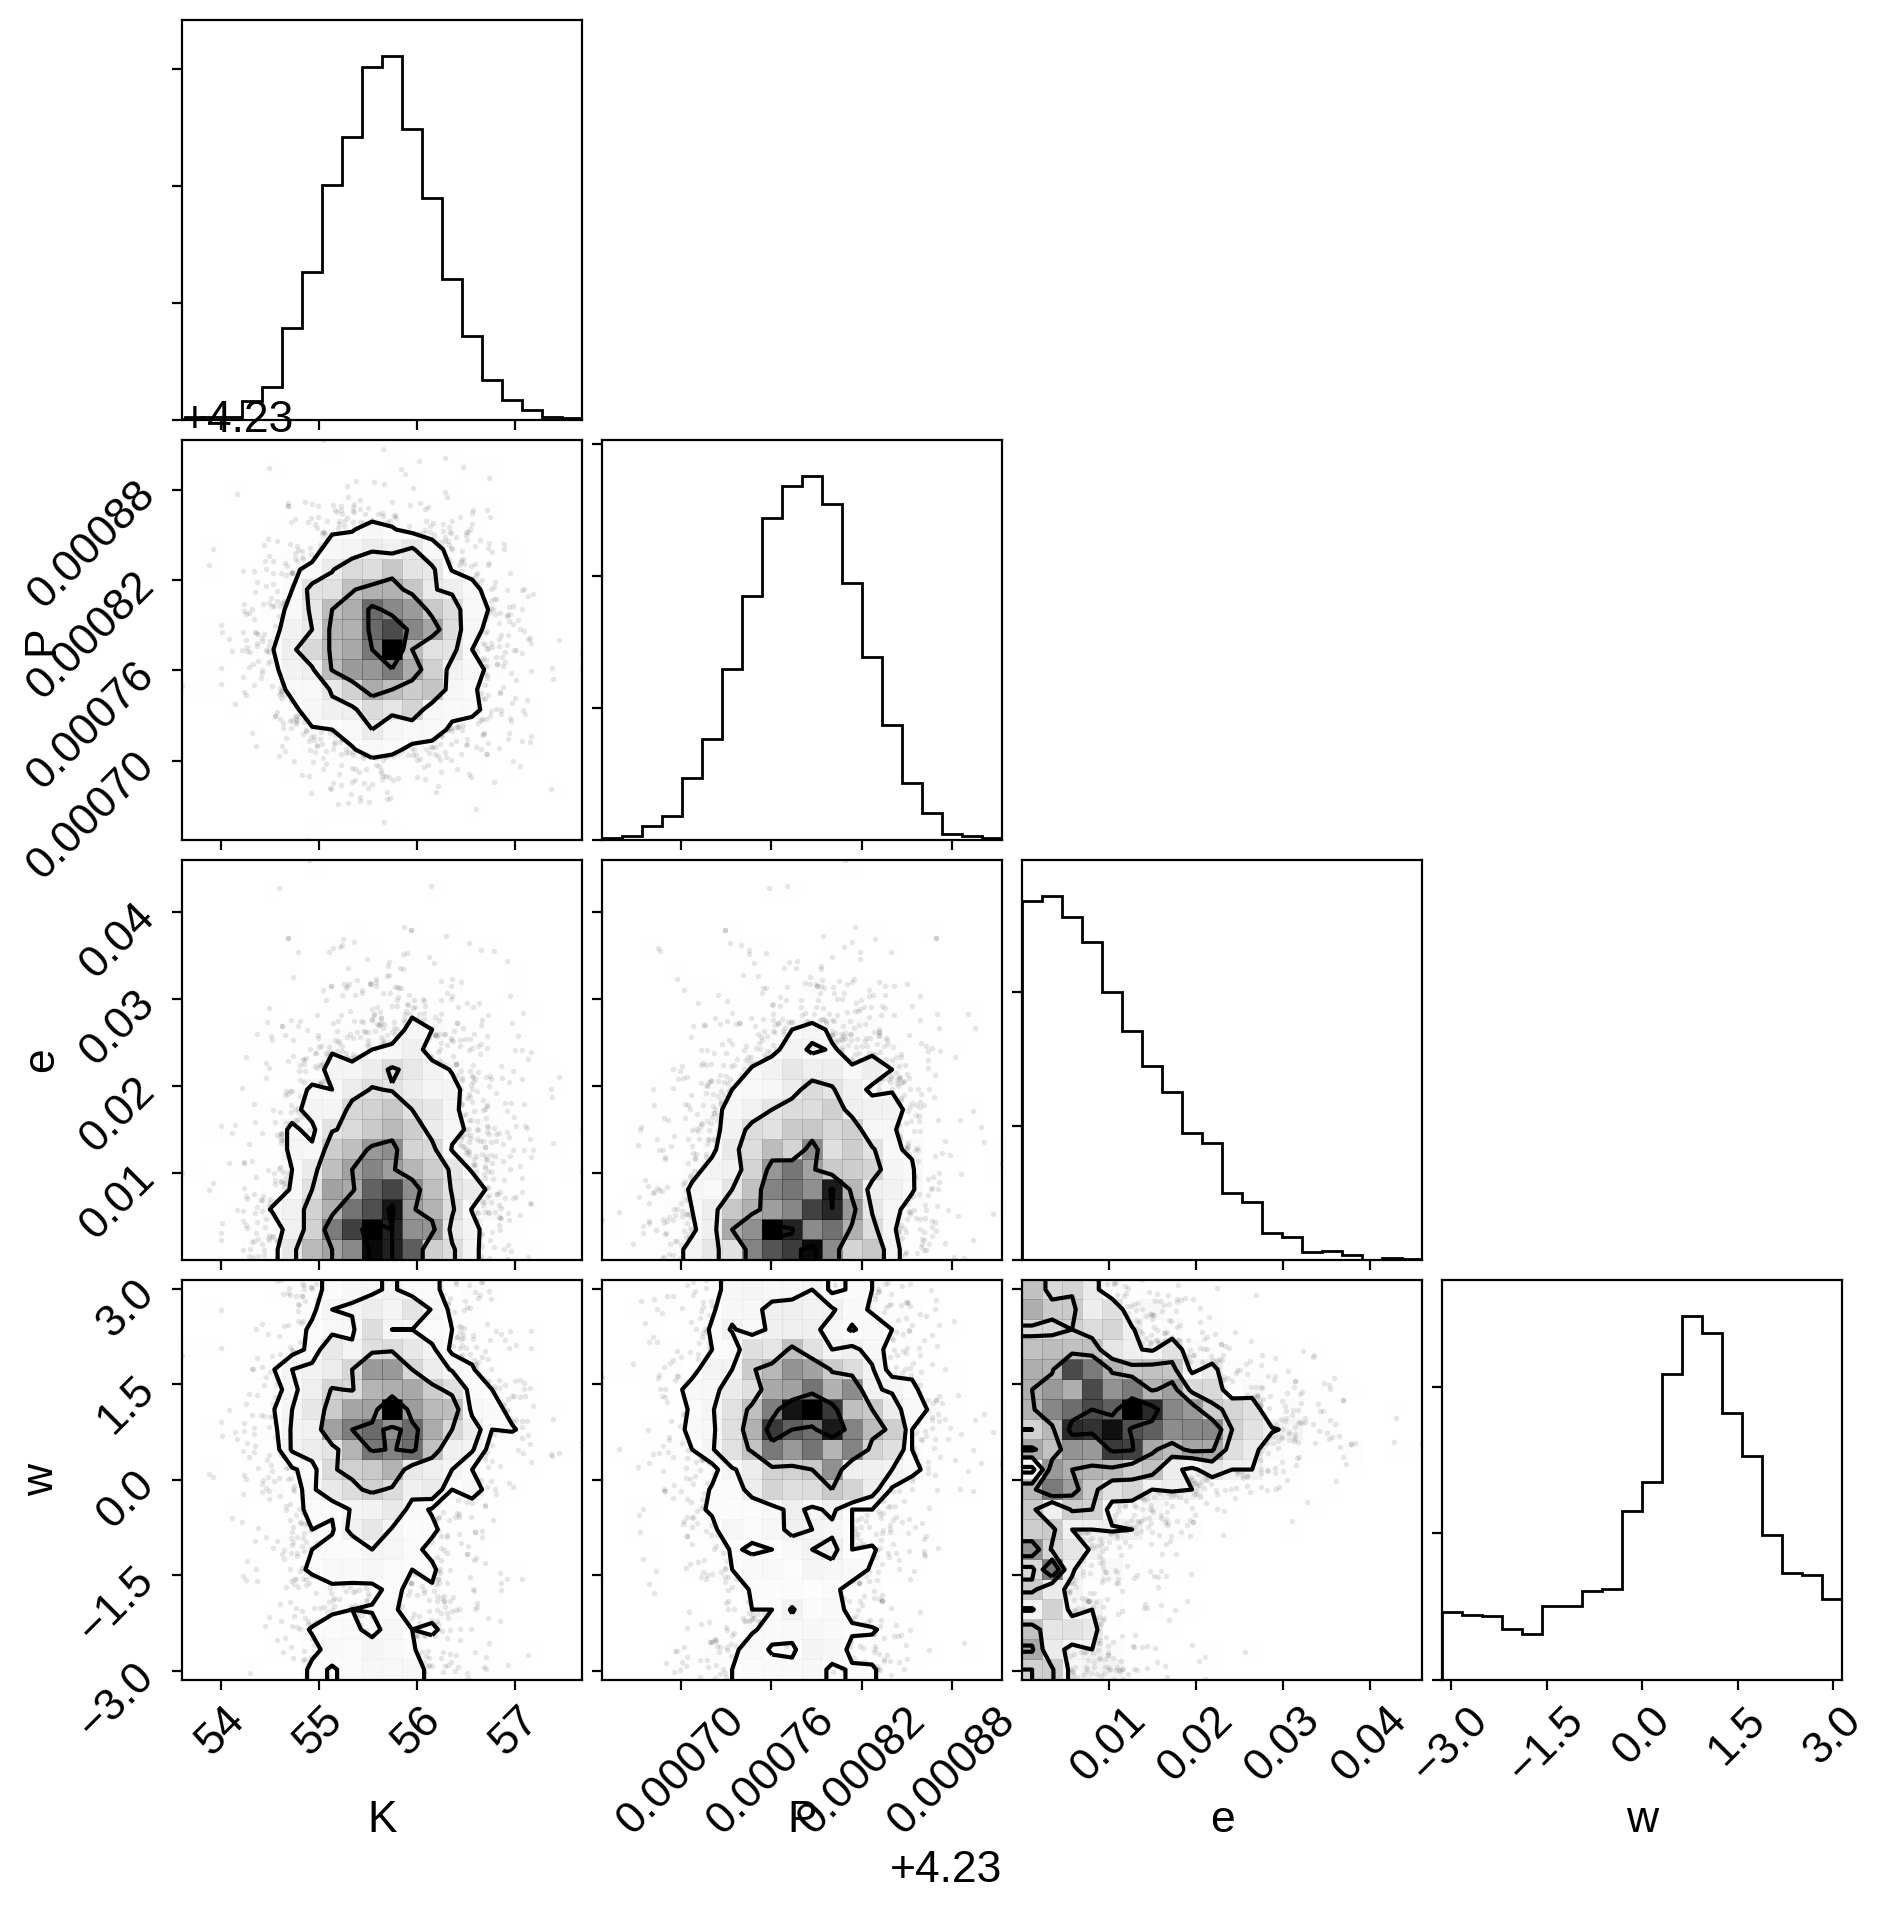

In [14]:
samples = pm.trace_to_dataframe(trace, varnames=["K", "P", "e", "w"])
_ = corner.corner(samples)

Finally, the last plot that we'll make here is of the posterior predictive density.
In this case, this means that we want to look at the distribution of predicted models that are consistent with the data.
As above, the top plot shows the raw observations as black error bars and the RV trend model is overplotted in blue.
But, this time, the blue line is actually composed of 25 lines that are samples from the posterior over trends that are consistent with the data.
In the bottom panel, the orange lines indicate the same 25 posterior samples for the RV curve of one orbit.

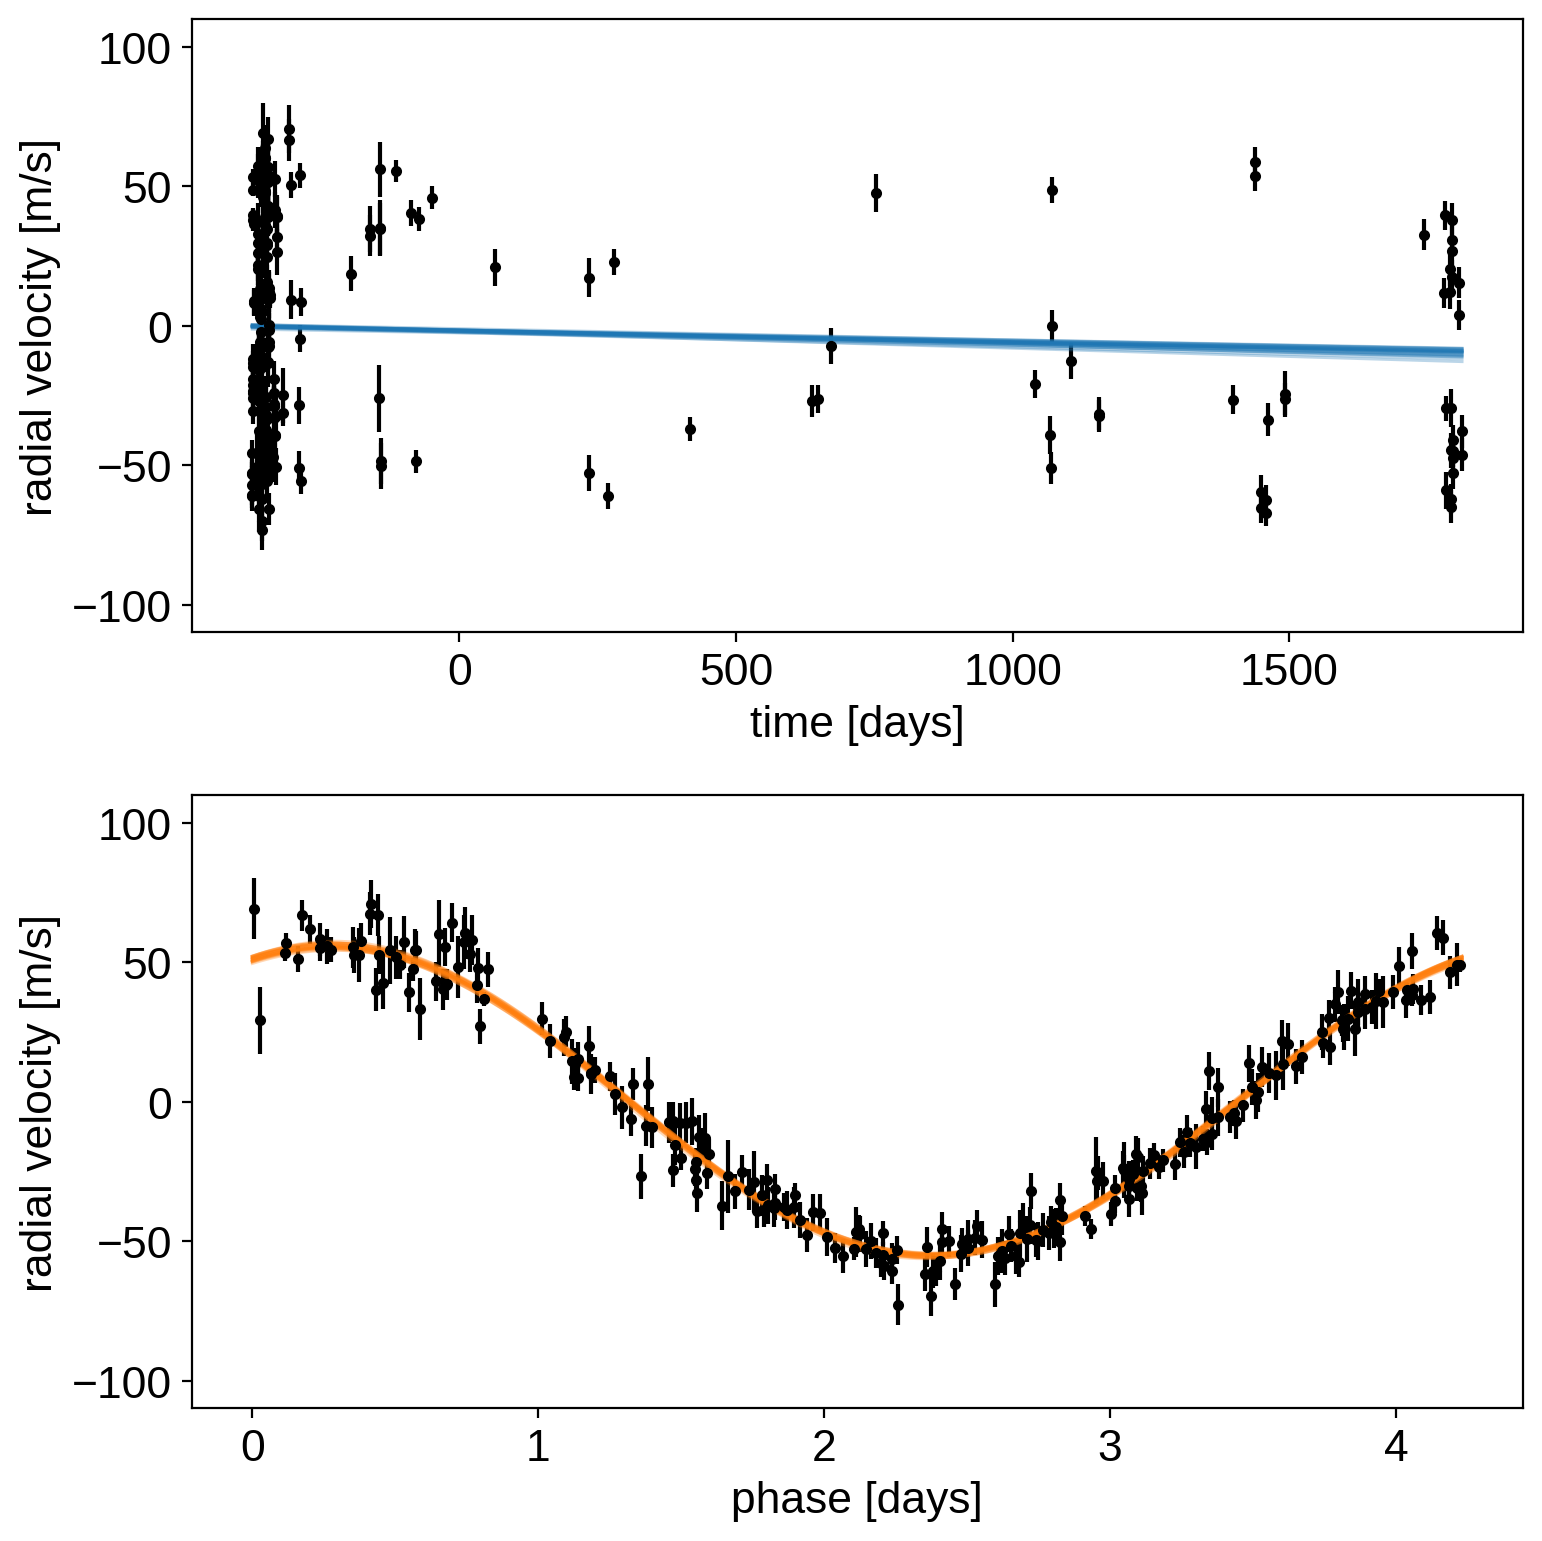

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8))

period = map_params["P"]

ax = axes[0]
ax.errorbar(t, rv, yerr=rv_err, fmt=".k")
ax.set_ylabel("radial velocity [m/s]")
ax.set_xlabel("time [days]")

ax = axes[1]
ax.errorbar(t % period, rv - map_params["bkg"], yerr=rv_err, fmt=".k")
ax.set_ylabel("radial velocity [m/s]")
ax.set_xlabel("phase [days]")

for i in np.random.randint(len(trace) * trace.nchains, size=25):
    axes[0].plot(t, trace["bkg"][i], color="C0", lw=1, alpha=0.3)
    axes[1].plot(
        phase * period, trace["rvphase"][i], color="C1", lw=1, alpha=0.3
    )

axes[0].set_ylim(-110, 110)
axes[1].set_ylim(-110, 110)

plt.tight_layout()